<a href="https://colab.research.google.com/github/Nyamadie/Dynamic-time-warping/blob/main/signal_similarity(Raw_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Packages

In [ ]:
!pip install "pandas<2.0.0" dtw-python plotly fastdtw dtaidistance

In [ ]:
import pickle
import pandas as pd
import numpy as np
from fastdtw import fastdtw
from google.colab import drive
import scipy.spatial.distance as dist
from scipy.spatial.distance import euclidean
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from dtw import dtw
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Read files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/QFHD'

In [ ]:
pickle_file_path = ""
meta_file_path = ''
# pickle_df = pd.read_pickle(pickle_file_path)

In [ ]:
with open(pickle_file_path, 'rb') as file:
  signal_data = pickle.load(file)
# meta = pd.read_excel(meta_file_path)
# meta.head()
  # signal_data.keys()
  # signal_data['file_data'].keys()

In [ ]:
meta = pd.read_excel(meta_file_path)
meta.info

In [ ]:
signal_data['file_data']['JO 03.05.21.3.csv']

In [ ]:
ppg_signals_df = signal_data['file_data']
# ppg_signals_df

In [ ]:
def read_patients_signals(patients, ppg_signals_df):
    results = {}

    for patient_file in patients:
        results[patient_file] = []
        for key in signal_data:
            try:
                # Ensuring the value associated with `key` is a dictionary and is not empty
                if isinstance(signal_data[key], dict):
                    if patient_file in signal_data[key]:
                        value = signal_data[key][patient_file]
                        results[patient_file].append((key, value))
                    else:
                        results[patient_file].append((key, f"{patient_file} key not found"))
                else:
                    results[patient_file].append((key, "Not a dictionary or empty dictionary"))
            except Exception as e:
                results[patient_file].append((key, f"Error: {str(e)}"))

    return results

## Analsing the data

In [ ]:
selected_ids = ['JO 03.05.21.3.csv', 'SH 07.06.21.2.csv']

In [ ]:
fig = make_subplots(rows=len(selected_ids), cols=1,
                    subplot_titles=selected_ids,
                    shared_xaxes=True,
                    vertical_spacing=0.1)

for i, id in enumerate(selected_ids, 1):
    df = ppg_signals_df[id]

    trace = go.Scatter(
        x=df.index,
        y=df['raw_data'],
        mode='lines',
        name=id
    )

    fig.add_trace(trace, row=i, col=1)


fig.update_layout(
    height=600*len(selected_ids),
    width=1000,
    title_text="PPG Signals Visualization",
    showlegend=False,
    template='plotly_dark'
)


fig.update_yaxes(title_text="Signal Amplitude", row=1, col=1)
fig.update_yaxes(title_text="Signal Amplitude", row=2, col=1)

fig.update_xaxes(title_text="Time", row=2, col=1)
fig.show()

In [ ]:
for id in selected_ids:
    df = ppg_signals_df[id]
    signal_length = len(df['raw_data'])
    print(f"Signal length for {id}: {signal_length}") # Signal lengths refer to the number of data points in each time series.

length_difference = abs(len(ppg_signals_df[selected_ids[0]]['raw_data']) -
                        len(ppg_signals_df[selected_ids[1]]['raw_data']))

print(f"\nDifference in signal lengths: {length_difference}")

Signal length for JO 03.05.21.3.csv: 2698
Signal length for SH 07.06.21.2.csv: 2572

Difference in signal lengths: 126


In [ ]:
signal1 = ppg_signals_df[selected_ids[0]]['raw_data'].values
signal2 = ppg_signals_df[selected_ids[1]]['raw_data'].values

min_length = min(len(signal1), len(signal2))
signal1 = signal1[:min_length]
signal2 = signal2[:min_length]

# 1. Euclidean distance
euclidean_dist = euclidean(signal1, signal2)

# 2. Correlation coefficient
correlation, _ = pearsonr(signal1, signal2)

print(f"Euclidean distance: {euclidean_dist}")
print(f"Correlation coefficient: {correlation}")

normalized_euclidean = euclidean_dist / np.sqrt(min_length)


print(f"\nNormalized Euclidean distance: {normalized_euclidean}")

Euclidean distance: 35585.09117594052
Correlation coefficient: 0.5094740428914774

Normalized Euclidean distance: 701.669502671865


In [ ]:
def compute_cost_matrix(X, Y, metric='euclidean'):
    """Compute the cost matrix of two feature sequences"""
    X, Y = np.atleast_2d(X, Y)
    C = dist.cdist(X.T, Y.T, metric=metric)
    return C

X = ppg_signals_df[selected_ids[0]]['raw_data'].values
Y = ppg_signals_df[selected_ids[1]]['raw_data'].values

C = compute_cost_matrix(X, Y, metric='euclidean')

print(f"Shape of cost matrix: {C.shape}")
print(f"Minimum cost: {np.min(C)}")
print(f"Maximum cost: {np.max(C)}")
print(f"Average cost: {np.mean(C)}")

Shape of cost matrix: (2698, 2572)
Minimum cost: 0.0
Maximum cost: 3104.0
Average cost: 760.2589825191634


## Normalization

In [ ]:
def normalize_all_columns(sign, scaler_type='minmax'):

    normalized_signals = {}

    # Choose the scaler
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("Invalid scaler_type. Use 'minmax' or 'standard'.")

    for patient_file, data in signals.items():
        print(f"Processing {patient_file}")

        # Extract the DataFrame from the `file_data` entry
        df = None
        for key, value in data:
            if key == 'file_data':
                df = value
                break

        if df is not None and isinstance(df, pd.DataFrame):
            # print(f"DataFrame:\n{df.head()}")

            # Separate out the 'Category' column and normalize the rest
            try:
                if 'Category' in df.columns:
                    category_col = df['Category']
                    df_numeric = df.select_dtypes(include=[np.number])

                    # Normalize numeric columns
                    normalized_df = pd.DataFrame(scaler.fit_transform(df_numeric),
                                                 columns=df_numeric.columns,
                                                 index=df.index)

                    # Add the 'Category' column back to the normalized DataFrame
                    normalized_df['Category'] = category_col

                    normalized_signals[patient_file] = normalized_df
                else:
                    normalized_signals[patient_file] = "Category column not found"
            except Exception as e:
                normalized_signals[patient_file] = f"Error: {str(e)}"
        else:
            normalized_signals[patient_file] = "Unexpected data format or empty data"

    return normalized_signals

    print(normalized_signals)


In [ ]:
healthy_patients = ['JO 03.05.21.3.csv', 'SH 07.06.21.2.csv']
signals = read_patients_signals(healthy_patients, ppg_signals_df)
signals

In [ ]:
healthy_patients = ['JO 03.05.21.3.csv', 'SH 07.06.21.2.csv']
signals = read_patients_signals(healthy_patients, ppg_signals_df)
normalized_signals = normalize_all_columns(signals, scaler_type='standard')
print(normalized_signals)

## GOOD PERFORMING HEALTHY PATIENTS

#### Normalize signal length

In [ ]:
for id in selected_ids:
    df = normalized_signals[id]
    signal_length = len(df['raw_data'])
    print(f"Normalized Signal length for {id}: {signal_length}") # Signal lengths refer to the number of data points in each time series.

length_difference = abs(len(normalized_signals[selected_ids[0]]['raw_data']) -
                        len(normalized_signals[selected_ids[1]]['raw_data']))

print(f"\nDifference in signal lengths: {length_difference}")

Normalized Signal length for JO 03.05.21.3.csv: 2698
Normalized Signal length for JA 06.11.21.3.csv: 2609

Difference in signal lengths: 89


#### CHANNEL SELECTION AND PATIENT COMPARISON

In [ ]:
def select_channel(signals, column_name):
    channel_signals = {}

    for patient_file, df in signals.items():
        if isinstance(df, pd.DataFrame):
            if column_name in df.columns:
                channel_signals[patient_file] = df[column_name]
            else:
                channel_signals[patient_file] = f"{column_name} not found in {patient_file}"
        else:
            channel_signals[patient_file] = "Data is not a DataFrame"

    return channel_signals

#### dtw Visualizations


In [ ]:
def compare_patients(patient, channel_signals, column_name):
    signal1 = channel_signals.get(patient[0])
    signal2 = channel_signals.get(patient[1])

    if isinstance(signal1, pd.Series) and isinstance(signal2, pd.Series):
        # Convert Series to numpy arrays
        signal1 = signal1.values
        signal2 = signal2.values

        # Ensure signals are 1-D arrays
        signal1 = np.ravel(signal1)
        signal2 = np.ravel(signal2)

        if len(signal1) == 0 or len(signal2) == 0:
            print(f"Signals for {patient[0]} or {patient[1]} are empty.")
            return

        # Compute DTW distance and path
        try:
            distance = dtw.distance(signal1, signal2)
            path = dtw.warping_path(signal1, signal2)
            print(f"DTW Distance between {patient[0]} and {patient[1]}: {distance:.2f}")

            # Create plotly figure
            fig = go.Figure()

            # Add traces for both patients' signals
            fig.add_trace(go.Scatter(
                x=list(range(len(signal1))),
                y=signal1,
                mode='lines',
                name=f'{patient[0]}',
                line=dict(color='blue', width=2)
            ))

            fig.add_trace(go.Scatter(
                x=list(range(len(signal2))),
                y=signal2,
                mode='lines',
                name=f'{patient[1]}',
                line=dict(color='red', width=2)
            ))

            # Add lines to show the DTW alignment
            for (index1, index2) in path:
                fig.add_trace(go.Scatter(
                    x=[index1, index2],
                    y=[signal1[index1], signal2[index2]],
                    mode='lines',
                    line=dict(color='gray', width=0.2),
                    showlegend=False
                ))

            fig.update_layout(
                title=f'DTW Alignment of {column_name} Signals for {patient[0]} and {patient[1]}',
                xaxis_title='Time',
                yaxis_title='Normalized Amplitude',
                legend_title='Patients',
                template='plotly_dark',
                font=dict(size=14)
            )

            # Show plot
            fig.show()

        except Exception as e:
            print(f"Error computing DTW: {str(e)}")
            print("Signal1 first few elements:", signal1[:5])
            print("Signal2 first few elements:", signal2[:5])
    else:
        print(f"Data for patient is missing or not a pandas Series.")

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JO 03.05.21.3.csv', 'SH 07.06.21.2.csv'),
    ('JFHC AI1 09.07.21.2.csv', 'JFHC SZ1 09.28.21.3.csv'),
    ('RK 03.03.21.1.csv', 'VF 02.26.21.2.csv'),
    ('IW 07.08.21.1.csv', 'WL 03.02.21.2.csv'),
    ('SY 03.05.21.2.csv', 'JK 06.10.21.3.csv')
]

# Function to perform DTW analysis for multiple pairs
def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        compare_patients(pair, channel_signals, selected_column)

# Assuming 'signals' contains all patient signals data read from the files
# and 'ppg_signals_df' is already loaded with the signal data

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')


Processing JO 03.05.21.3.csv
Processing JFHC AI1 09.07.21.2.csv
Processing RK 03.03.21.1.csv
Processing IW 07.08.21.1.csv
Processing SY 03.05.21.2.csv
Processing SH 07.06.21.2.csv
Processing JFHC SZ1 09.28.21.3.csv
Processing VF 02.26.21.2.csv
Processing WL 03.02.21.2.csv
Processing JK 06.10.21.3.csv

Analyzing pair: ('JO 03.05.21.3.csv', 'SH 07.06.21.2.csv')
DTW Distance between JO 03.05.21.3.csv and SH 07.06.21.2.csv: 23.95



Analyzing pair: ('JFHC AI1 09.07.21.2.csv', 'JFHC SZ1 09.28.21.3.csv')
DTW Distance between JFHC AI1 09.07.21.2.csv and JFHC SZ1 09.28.21.3.csv: 28.58



Analyzing pair: ('RK 03.03.21.1.csv', 'VF 02.26.21.2.csv')
DTW Distance between RK 03.03.21.1.csv and VF 02.26.21.2.csv: 22.29



Analyzing pair: ('IW 07.08.21.1.csv', 'WL 03.02.21.2.csv')
DTW Distance between IW 07.08.21.1.csv and WL 03.02.21.2.csv: 36.53



Analyzing pair: ('SY 03.05.21.2.csv', 'JK 06.10.21.3.csv')
DTW Distance between SY 03.05.21.2.csv and JK 06.10.21.3.csv: 43.73


In [ ]:
patient_pairs = [
    ('JO 03.05.21.3.csv', 'SH 07.06.21.2.csv'),
    ('JFHC AI1 09.07.21.2.csv', 'JFHC SZ1 09.28.21.3.csv'),
    ('RK 03.03.21.1.csv', 'VF 02.26.21.2.csv'),
    ('IW 07.08.21.1.csv', 'WL 03.02.21.2.csv'),
    ('SY 03.05.21.2.csv', 'JK 06.10.21.3.csv')
]

In [ ]:
#  Step 1: Create a distance matrix using DTW distances
def create_distance_matrix(channel_signals, patient_files):
    num_patients = len(patient_files)
    distance_matrix = np.zeros((num_patients, num_patients))

    for i in range(num_patients):
        for j in range(i + 1, num_patients):
            signal1 = channel_signals.get(patient_files[i])
            signal2 = channel_signals.get(patient_files[j])

            if isinstance(signal1, pd.Series) and isinstance(signal2, pd.Series):
                distance_matrix[i, j] = dtw.distance(signal1.values, signal2.values)
                distance_matrix[j, i] = distance_matrix[i, j]

    return distance_matrix

# Step 2: Perform k-medoids clustering
def k_medoids_clustering(distance_matrix, num_clusters):
    kmedoids_instance = clustering.KMedoids(k=num_clusters)
    clusters = kmedoids_instance.fit(distance_matrix)
    return clusters

# Step 3: Analyze clustering results
def analyze_clusters(patient_files, clusters):
    cluster_map = {}
    for i, cluster in enumerate(clusters):
        if cluster not in cluster_map:
            cluster_map[cluster] = []
        cluster_map[cluster].append(patient_files[i])

    for cluster, patients in cluster_map.items():
        print(f"Cluster {cluster}: {patients}")

# Main function for clustering analysis
def clustering_analysis(patient_pairs, signals, selected_column, scaler_type='standard', num_clusters=3):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    # Combine patient files from pairs
    patient_files = [p[0] for p in patient_pairs] + [p[1] for p in patient_pairs]

    # Create distance matrix based on DTW
    distance_matrix = create_distance_matrix(channel_signals, patient_files)

    # Perform k-medoids clustering
    clusters = k_medoids_clustering(distance_matrix, num_clusters)

    # Analyze clustering results
    analyze_clusters(patient_files, clusters)

# Run the clustering analysis
clustering_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard', num_clusters=3)


#### Warping path

In [ ]:
def visualize_warping_path(patient, channel_signals, column_name):
    signal1 = channel_signals.get(patient[0])
    signal2 = channel_signals.get(patient[1])

    if isinstance(signal1, pd.Series) and isinstance(signal2, pd.Series):
        # Convert Series to numpy arrays
        signal1 = signal1.values
        signal2 = signal2.values

        # Ensure signals are 1-D arrays
        signal1 = np.ravel(signal1)
        signal2 = np.ravel(signal2)

        if len(signal1) == 0 or len(signal2) == 0:
            print(f"Signals for {patient[0]} or {patient[1]} are empty.")
            return

        # Compute DTW distance and path
        try:
            d, paths = dtw.warping_paths(signal1, signal2)
            best_path = dtw.best_path(paths)
            print(f"DTW Distance between {patient[0]} and {patient[1]}: {d:.2f}")

            # Create the warping paths plot
            fig = dtwvis.plot_warpingpaths(signal1, signal2, paths, best_path)

            # Update layout
            fig.update_layout(
                title=f'DTW Warping Path for {column_name} Signals of {patient[0]} and {patient[1]}',
                xaxis_title='Signal 1 Index',
                yaxis_title='Signal 2 Index',
                template='dark',
                font=dict(size=14)
            )

            # Show plot
            fig.show()

        except Exception as e:
            print(f"Error computing DTW: {str(e)}")
            print("Signal1 first few elements:", signal1[:5])
            print("Signal2 first few elements:", signal2[:5])
    else:
        print(f"Data for patient is missing or not a pandas Series.")

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JO 03.05.21.3.csv', 'SH 07.06.21.2.csv'),
    ('JFHC AI1 09.07.21.2.csv', 'JFHC SZ1 09.28.21.3.csv'),
    ('RK 03.03.21.1.csv', 'VF 02.26.21.2.csv'),
    ('IW 07.08.21.1.csv', 'WL 03.02.21.2.csv'),
    ('SY 03.05.21.2.csv', 'JK 06.10.21.3.csv')
]

# Function to perform DTW analysis for multiple pairs
def warping_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair\n: {pair}")
        visualize_warping_path(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
warping_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')


#### Segmentation

In [ ]:
def select_channel_by_category(signals, column_name):
    channel_signals = {}

    for patient_file, df in signals.items():
        if isinstance(df, pd.DataFrame):
            if column_name in df.columns and 'Category' in df.columns:
                grouped = df.groupby('Category')[column_name]
                channel_signals[patient_file] = {
                    category: group for category, group in grouped
                }
            else:
                channel_signals[patient_file] = f"{column_name} or Category not found in {patient_file}"
        else:
            channel_signals[patient_file] = "Data is not a DataFrame"

    return channel_signals

In [ ]:
def compare_patients_by_category(patient, channel_signals, column_name):
    signal1 = channel_signals.get(patient[0])
    signal2 = channel_signals.get(patient[1])

    if isinstance(signal1, dict) and isinstance(signal2, dict):
      categories = ['Whistle', 'Expiration', 'Recovery']        # categories = ['Baseline', 'Recovery', , 'Expiration']


      for category in categories:
            if category in signal1 and category in signal2:
                s1 = signal1[category].values
                s2 = signal2[category].values

                # Ensure signals are 1-D arrays
                s1 = np.ravel(s1)
                s2 = np.ravel(s2)

                if len(s1) == 0 or len(s2) == 0:
                    print(f"Signals for {patient[0]} or {patient[1]} are empty for category {category}.")
                    continue

                # Compute DTW distance and path
                try:
                    distance = dtw.distance(s1, s2)
                    path = dtw.warping_path(s1, s2)
                    print(f"DTW Distance between {patient[0]} and {patient[1]} for {category}: {distance:.2f}")

                    # Create plotly figure
                    fig = go.Figure()

                    # Add traces for both patients' signals
                    fig.add_trace(go.Scatter(
                        x=list(range(len(s1))),
                        y=s1,
                        mode='lines',
                        name=f'{patient[0]}',
                        line=dict(color='blue', width=2)
                    ))

                    fig.add_trace(go.Scatter(
                        x=list(range(len(s2))),
                        y=s2,
                        mode='lines',
                        name=f'{patient[1]}',
                        line=dict(color='red', width=2)
                    ))

                    # Add lines to show the DTW alignment
                    for (index1, index2) in path:
                        fig.add_trace(go.Scatter(
                            x=[index1, index2],
                            y=[s1[index1], s2[index2]],
                            mode='lines',
                            line=dict(color='gray', width=0.2),
                            showlegend=False
                        ))

                    fig.update_layout(
                        title=f'DTW Alignment of {column_name} Signals for {patient[0]} and {patient[1]} - {category}',
                        xaxis_title='Time',
                        yaxis_title='Normalized Amplitude',
                        legend_title='Patients',
                        template='plotly_dark',
                        font=dict(size=14)
                    )

                    # Show plot
                    fig.show()

                except Exception as e:
                    print(f"Error computing DTW for {category}: {str(e)}")
                    print(f"Signal1 first few elements for {category}:", s1[:5])
                    print(f"Signal2 first few elements for {category}:", s2[:5])
            else:
                print(f"Category {category} not found for both patients.")
    else:
        print(f"Data for patient is missing or not in the correct format.")

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JO 03.05.21.3.csv', 'SH 07.06.21.2.csv'),
    ('JFHC AI1 09.07.21.2.csv', 'JFHC SZ1 09.28.21.3.csv'),
    ('RK 03.03.21.1.csv', 'VF 02.26.21.2.csv'),
    ('IW 07.08.21.1.csv', 'WL 03.02.21.2.csv'),
    ('SY 03.05.21.2.csv', 'JK 06.10.21.3.csv')
]

# Function to perform DTW analysis for multiple pairs
def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel_by_category(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        compare_patients_by_category(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')


####Segmentation for the warping path

In [ ]:
def visualize_warping_path(patient, channel_signals, column_name):
    signal1 = channel_signals.get(patient[0])
    signal2 = channel_signals.get(patient[1])

    if isinstance(signal1, dict) and isinstance(signal2, dict):
        categories = ['Whistle', 'Expiration']  #'Baseline', 'Recovery',

        for category in categories:
            if category in signal1 and category in signal2:
                s1 = signal1[category].values
                s2 = signal2[category].values

                # Ensure signals are 1-D arrays
                s1 = np.ravel(s1)
                s2 = np.ravel(s2)

                if len(s1) == 0 or len(s2) == 0:
                    print(f"Signals for {patient[0]} or {patient[1]} are empty for category {category}.")
                    continue

                # Compute DTW distance and path
                try:
                    d, paths = dtw.warping_paths(s1, s2)
                    best_path = dtw.best_path(paths)
                    print(f"DTW Distance between {patient[0]} and {patient[1]} for {category}: {d:.2f}")

                    # Create the warping paths plot with customizations
                    fig, ax = dtwvis.plot_warpingpaths(s1, s2, paths, best_path)

                    # Customizing the plot
                    ax.set_title(f'DTW Warping Path for {column_name} Signals of {patient[0]} and {patient[1]} - {category}', fontsize=16, weight='bold', color='darkblue')
                    ax.set_xlabel('Signal 1 Index', fontsize=14, weight='bold')
                    ax.set_ylabel('Signal 2 Index', fontsize=14, weight='bold')

                    # Set the grid and background color
                    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
                    ax.set_facecolor('whitesmoke')

                    # Adjust the color map and line styles
                    cmap = plt.get_cmap('coolwarm')
                    ax.imshow(paths.T, cmap=cmap, aspect='auto')

                    # Set tick parameters
                    ax.tick_params(axis='both', which='major', labelsize=12, colors='black')

                    # Customize the path line
                    for line in ax.get_lines():
                        line.set_linestyle('-')
                        line.set_linewidth(2)
                        line.set_color('darkred')

                    plt.show()

                except Exception as e:
                    print(f"Error computing DTW for {category}: {str(e)}")
                    print(f"Signal1 first few elements for {category}:", s1[:5])
                    print(f"Signal2 first few elements for {category}:", s2[:5])
            else:
                print(f"Category {category} not found for both patients.")
    else:
        print(f"Data for patient is missing or not in the correct format.")

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JO 03.05.21.3.csv', 'SH 07.06.21.2.csv'),
    ('JFHC AI1 09.07.21.2.csv', 'JFHC SZ1 09.28.21.3.csv'),
    ('RK 03.03.21.1.csv', 'VF 02.26.21.2.csv'),
    ('IW 07.08.21.1.csv', 'WL 03.02.21.2.csv'),
    ('SY 03.05.21.2.csv', 'JK 06.10.21.3.csv')
]

# Function to perform DTW analysis for multiple pairs
def warping_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel_by_category(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        visualize_warping_path(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
warping_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')


## GOOD PERFORMING UNHEALTHY PATIENTS


#### Selected ids

In [ ]:
selected_ids = ['BHRT BD1 09.29.21.3.csv', 'JFHC MV1 10.19.21.2.csv']

In [ ]:
unhealthy_patients = ['BHRT BD1 09.29.21.3.csv', 'JFHC MV1 10.19.21.2.csv']
signals = read_patients_signals(unhealthy_patients, ppg_signals_df)

In [ ]:
unhealthy_patients = ['BHRT BD1 09.29.21.3.csv', 'JFHC MV1 10.19.21.2.csv']
signals = read_patients_signals(unhealthy_patients, ppg_signals_df)
normalized_signals = normalize_all_columns(signals, scaler_type='standard')
# print(normalized_signals)

Processing BHRT BD1 09.29.21.3.csv
Processing JFHC MV1 10.19.21.2.csv


#### Normalized signal length

In [ ]:
for id in selected_ids:
    df = ppg_signals_df[id]
    signal_length = len(df['raw_data'])
    print(f"Signal length for {id}: {signal_length}") # Signal lengths refer to the number of data points in each time series.

length_difference = abs(len(ppg_signals_df[selected_ids[0]]['raw_data']) -
                        len(ppg_signals_df[selected_ids[1]]['raw_data']))

print(f"\nDifference in signal lengths: {length_difference}")

Signal length for BHRT BD1 09.29.21.3.csv: 2502
Signal length for JFHC MV1 10.19.21.2.csv: 2774

Difference in signal lengths: 272


#### Signal visualization

In [ ]:
fig = make_subplots(rows=len(selected_ids), cols=1,
                    subplot_titles=selected_ids,
                    shared_xaxes=True,
                    vertical_spacing=0.1)

for i, id in enumerate(selected_ids, 1):
    if id in normalized_signals:
        df = normalized_signals[id]

        trace = go.Scatter(
            x=df.index,
            y=df['raw_data'],
            mode='lines',
            name=id
        )


        fig.add_trace(trace, row=i, col=1)
    else:
        print(f"Skipping {id} due to missing or invalid data.")


fig.update_layout(
    height=600*len(selected_ids),
    width=1000,
    title_text="Normalized PPG Signals Visualization",
    showlegend=False,
    template='plotly_dark'
)


fig.update_yaxes(title_text="Normalized Signal Amplitude", row=1, col=1)
fig.update_yaxes(title_text="Normalized Signal Amplitude", row=2, col=1)


fig.update_xaxes(title_text="Time", row=2, col=1)

fig.show()

#### DTW visualization

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('BHRT BD1 09.29.21.3.csv', 'JFHC MV1 10.19.21.2.csv'),
    ('JA 06.11.21.3.csv', 'BHRT KR1 09.29.21.3.csv'),
    ('BHRT MT1 10.20.21.1.csv', 'JFHC MV1 10.19.21.1.csv'),
]

# Function to perform DTW analysis for multiple pairs
def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        compare_patients(pair, channel_signals, selected_column)

# Assuming 'signals' contains all patient signals data read from the files
# and 'ppg_signals_df' is already loaded with the signal data

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')


#### Warping Path

Processing BHRT BD1 09.29.21.3.csv
Processing JA 06.11.21.3.csv
Processing BHRT MT1 10.20.21.1.csv
Processing JFHC MV1 10.19.21.2.csv
Processing BHRT KR1 09.29.21.3.csv
Processing JFHC MV1 10.19.21.1.csv

Analyzing pair
: ('BHRT BD1 09.29.21.3.csv', 'JFHC MV1 10.19.21.2.csv')
DTW Distance between BHRT BD1 09.29.21.3.csv and JFHC MV1 10.19.21.2.csv: 34.42
Error computing DTW: 'tuple' object has no attribute 'update_layout'
Signal1 first few elements: [0.34357739 0.37572664 0.40787588 0.42930871 0.44538334]
Signal2 first few elements: [1.44356106 1.50642552 1.57394661 1.62982614 1.68337735]

Analyzing pair
: ('JA 06.11.21.3.csv', 'BHRT KR1 09.29.21.3.csv')
DTW Distance between JA 06.11.21.3.csv and BHRT KR1 09.29.21.3.csv: 23.88
Error computing DTW: 'tuple' object has no attribute 'update_layout'
Signal1 first few elements: [0.42579759 0.45494506 0.47942894 0.50391282 0.52256721]
Signal2 first few elements: [-0.27801113 -0.48654743 -0.69740081 -0.83410795 -0.90130298]

Analyzing pair
: (

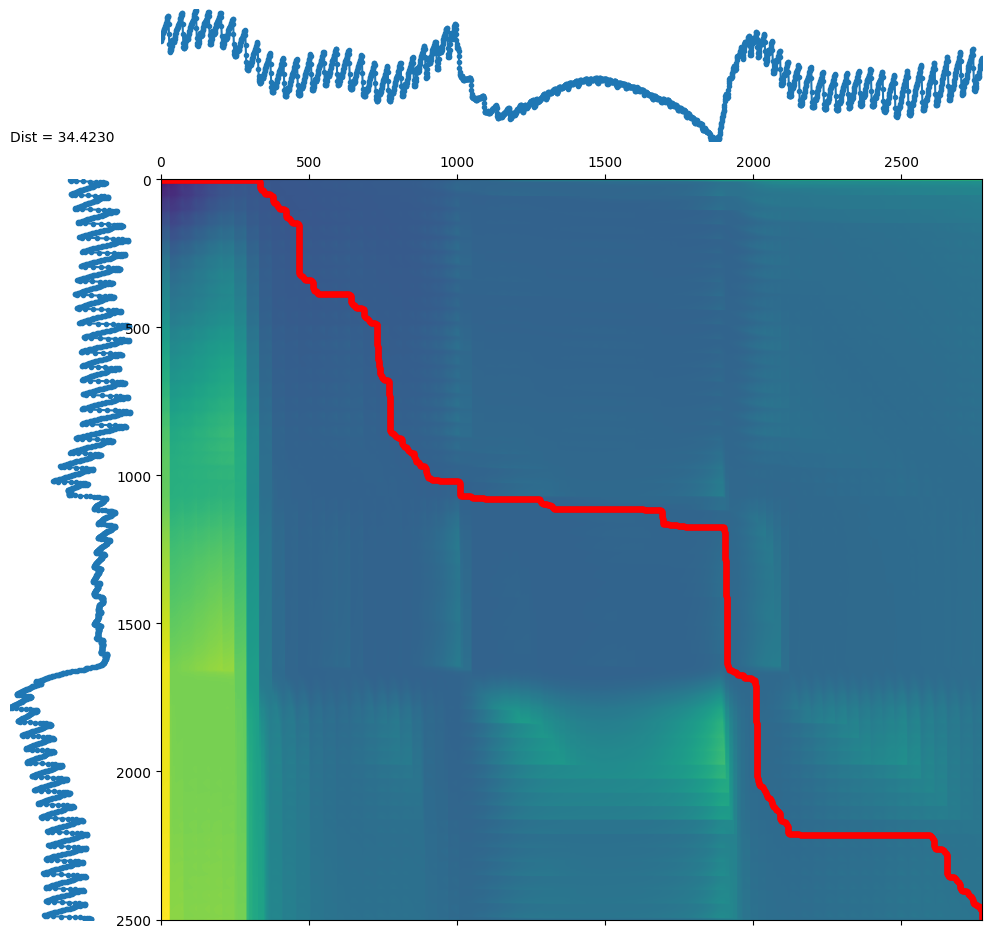

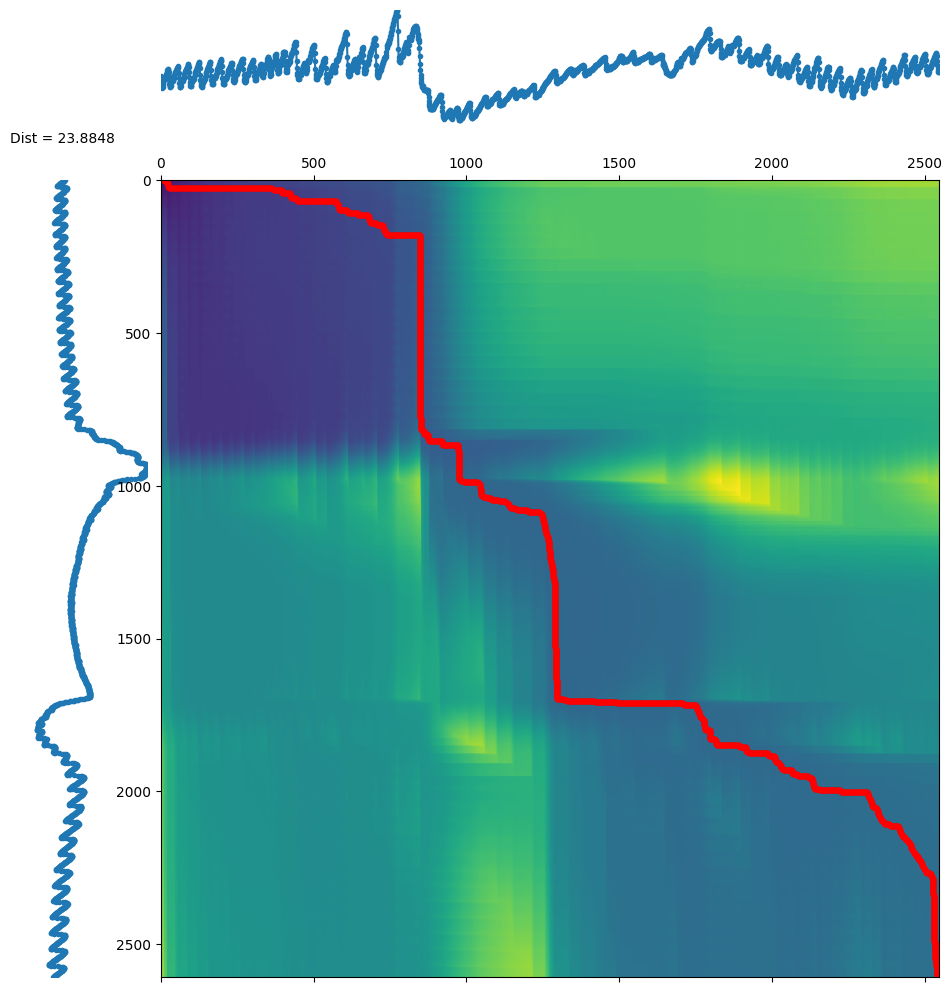

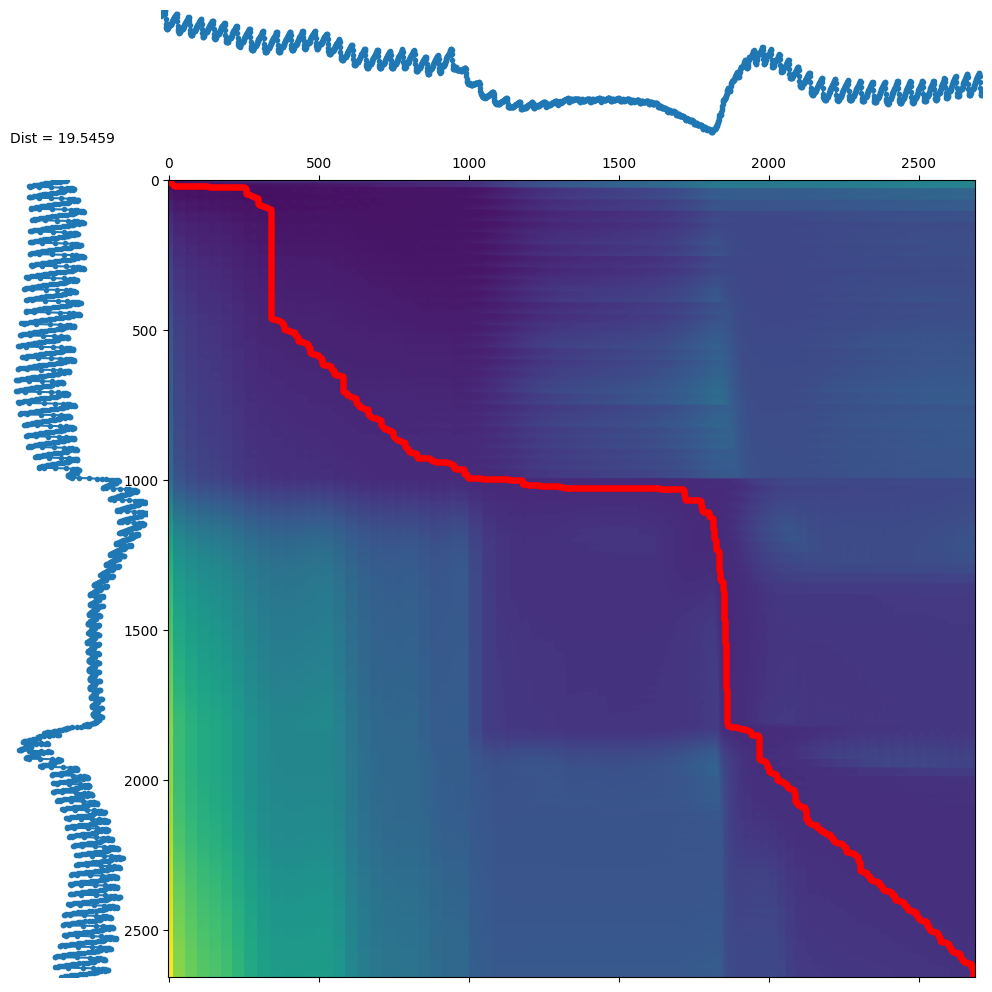

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('BHRT BD1 09.29.21.3.csv', 'JFHC MV1 10.19.21.2.csv'),
    ('JA 06.11.21.3.csv', 'BHRT KR1 09.29.21.3.csv'),
    ('BHRT MT1 10.20.21.1.csv', 'JFHC MV1 10.19.21.1.csv'),
]

# Function to perform DTW analysis for multiple pairs
def warping_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair\n: {pair}")
        visualize_warping_path(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
warping_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')


#### Segmentation

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('BHRT BD1 09.29.21.3.csv', 'JFHC MV1 10.19.21.2.csv'),
    ('JA 06.11.21.3.csv', 'BHRT KR1 09.29.21.3.csv'),
    ('BHRT MT1 10.20.21.1.csv', 'JFHC MV1 10.19.21.1.csv'),
]

# Function to perform DTW analysis for multiple pairs
def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel_by_category(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        compare_patients_by_category(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')


#### Segmentation by warping path

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('BHRT BD1 09.29.21.3.csv', 'JFHC MV1 10.19.21.2.csv'),
    ('JA 06.11.21.3.csv', 'BHRT KR1 09.29.21.3.csv'),
    ('BHRT MT1 10.20.21.1.csv', 'JFHC MV1 10.19.21.1.csv'),
]

# Function to perform DTW analysis for multiple pairs
def warping_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel_by_category(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        visualize_warping_path(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
warping_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')
 #histogram of the distinct group

## **BAD PERFORMING HEALTHY PATIENTS**

#### selected ids

In [ ]:
selected_ids = ['JM 05.18.21.3.csv', 'IW 07.08.21.3.csv']

In [ ]:
healthy_patient = ['JM 05.18.21.3.csv', 'IW 07.08.21.3.csv']
signals = read_patients_signals(healthy_patient, ppg_signals_df)
signals

In [ ]:
healthy_patient = ['JM 05.18.21.3.csv', 'IW 07.08.21.3.csv']
signals = read_patients_signals(healthy_patient, ppg_signals_df)
normalized_signals = normalize_all_columns(signals, scaler_type='standard')
print(normalized_signals)

#### Normalize signal length

In [ ]:
for id in selected_ids:
    df = ppg_signals_df[id]
    signal_length = len(df['raw_data'])
    print(f"Signal length for {id}: {signal_length}") # Signal lengths refer to the number of data points in each time series.

length_difference = abs(len(ppg_signals_df[selected_ids[0]]['raw_data']) -
                        len(ppg_signals_df[selected_ids[1]]['raw_data']))

print(f"\nDifference in signal lengths: {length_difference}")

Signal length for JM 05.18.21.3.csv: 2793
Signal length for IW 07.08.21.3.csv: 2432

Difference in signal lengths: 361


#### signal visualization

In [ ]:
fig = make_subplots(rows=len(selected_ids), cols=1,
                    subplot_titles=selected_ids,
                    shared_xaxes=True,
                    vertical_spacing=0.1)

for i, id in enumerate(selected_ids, 1):
    if id in normalized_signals:
        df = normalized_signals[id]

        trace = go.Scatter(
            x=df.index,
            y=df['raw_data'],
            mode='lines',
            name=id
        )


        fig.add_trace(trace, row=i, col=1)
    else:
        print(f"Skipping {id} due to missing or invalid data.")


fig.update_layout(
    height=600*len(selected_ids),
    width=1000,
    title_text="Normalized PPG Signals Visualization",
    showlegend=False,
    template='plotly_dark'
)


fig.update_yaxes(title_text="Normalized Signal Amplitude", row=1, col=1)
fig.update_yaxes(title_text="Normalized Signal Amplitude", row=2, col=1)


fig.update_xaxes(title_text="Time", row=2, col=1)

fig.show()

#### dtw visualization

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JM 05.18.21.3.csv', 'IW 07.08.21.3.csv'),
    ('JFHC GY1 10.12.21.3.csv', 'JFHC JC1 08.24.21.3.csv'),
    ('HX 06.03.21.1.csv', 'QN 06.29.21.3.csv'),
    ('JFHC SZ1 09.28.21.2.csv', 'IW 07.08.21.2.csv'),
]

# Function to perform DTW analysis for multiple pairs
def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        compare_patients(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')


Processing JM 05.18.21.3.csv
Processing JFHC GY1 10.12.21.3.csv
Processing HX 06.03.21.1.csv
Processing JFHC SZ1 09.28.21.2.csv
Processing IW 07.08.21.3.csv
Processing JFHC JC1 08.24.21.3.csv
Processing QN 06.29.21.3.csv
Processing IW 07.08.21.2.csv

Analyzing pair: ('JM 05.18.21.3.csv', 'IW 07.08.21.3.csv')
DTW Distance between JM 05.18.21.3.csv and IW 07.08.21.3.csv: 26.62



Analyzing pair: ('JFHC GY1 10.12.21.3.csv', 'JFHC JC1 08.24.21.3.csv')
DTW Distance between JFHC GY1 10.12.21.3.csv and JFHC JC1 08.24.21.3.csv: 13.75



Analyzing pair: ('HX 06.03.21.1.csv', 'QN 06.29.21.3.csv')
DTW Distance between HX 06.03.21.1.csv and QN 06.29.21.3.csv: 28.70



Analyzing pair: ('JFHC SZ1 09.28.21.2.csv', 'IW 07.08.21.2.csv')
DTW Distance between JFHC SZ1 09.28.21.2.csv and IW 07.08.21.2.csv: 21.54


#### warping path

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JM 05.18.21.3.csv', 'IW 07.08.21.3.csv'),
    ('JFHC GY1 10.12.21.3.csv', 'JFHC JC1 08.24.21.3.csv'),
    ('HX 06.03.21.1.csv', 'QN 06.29.21.3.csv'),
    ('JFHC SZ1 09.28.21.2.csv', 'IW 07.08.21.2.csv'),
]

# Function to perform DTW analysis for multiple pairs
def warping_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair\n: {pair}")
        visualize_warping_path(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
warping_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')


#### segmentation

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JM 05.18.21.3.csv', 'IW 07.08.21.3.csv'),
    ('JFHC GY1 10.12.21.3.csv', 'JFHC JC1 08.24.21.3.csv'),
    ('HX 06.03.21.1.csv', 'QN 06.29.21.3.csv'),
    ('JFHC SZ1 09.28.21.2.csv', 'IW 07.08.21.2.csv'),
]

# Function to perform DTW analysis for multiple pairs
def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel_by_category(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        compare_patients_by_category(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')


#### segmentation by warping path

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JM 05.18.21.3.csv', 'IW 07.08.21.3.csv'),
    ('JFHC GY1 10.12.21.3.csv', 'JFHC JC1 08.24.21.3.csv'),
    ('HX 06.03.21.1.csv', 'QN 06.29.21.3.csv'),
    ('JFHC SZ1 09.28.21.2.csv', 'IW 07.08.21.2.csv'),
]

# Function to perform DTW analysis for multiple pairs
def warping_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel_by_category(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        visualize_warping_path(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
warping_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')
 #histogram of the distinct group

## BAD PERFORMING UNHEALTHY PATIENTS

#### Selected ids

In [ ]:
selected_ids = ['JFHC SL1 10.12.21.3.csv', 'BHRT KH1 10.06.21.3.csv']

In [ ]:
unhealthy_patients = ['JFHC SL1 10.12.21.3.csv', 'BHRT KH1 10.06.21.3.csv']
signals = read_patients_signals(unhealthy_patients, ppg_signals_df)
signals

In [ ]:
unhealthy_patients = ['JFHC SL1 10.12.21.3.csv', 'BHRT KH1 10.06.21.3.csv']
signals = read_patients_signals(unhealthy_patients, ppg_signals_df)
signals

#### Normalized signal length

In [ ]:
for id in selected_ids:
    df = ppg_signals_df[id]
    signal_length = len(df['raw_data'])
    print(f"Signal length for {id}: {signal_length}") # Signal lengths refer to the number of data points in each time series.

length_difference = abs(len(ppg_signals_df[selected_ids[0]]['raw_data']) -
                        len(ppg_signals_df[selected_ids[1]]['raw_data']))

print(f"\nDifference in signal lengths: {length_difference}")

Signal length for JFHC SL1 10.12.21.3.csv: 2617
Signal length for BHRT KH1 10.06.21.3.csv: 2442

Difference in signal lengths: 175


#### signal visualization

In [ ]:
fig = make_subplots(rows=len(selected_ids), cols=1,
                    subplot_titles=selected_ids,
                    shared_xaxes=True,
                    vertical_spacing=0.1)

for i, id in enumerate(selected_ids, 1):
    if id in normalized_signals:
        df = normalized_signals[id]

        trace = go.Scatter(
            x=df.index,
            y=df['raw_data'],
            mode='lines',
            name=id
        )


        fig.add_trace(trace, row=i, col=1)
    else:
        print(f"Skipping {id} due to missing or invalid data.")


fig.update_layout(
    height=600*len(selected_ids),
    width=1000,
    title_text="Normalized PPG Signals Visualization",
    showlegend=False,
    template='plotly_dark'
)


fig.update_yaxes(title_text="Normalized Signal Amplitude", row=1, col=1)
fig.update_yaxes(title_text="Normalized Signal Amplitude", row=2, col=1)


fig.update_xaxes(title_text="Time", row=2, col=1)

fig.show()

####DTW visualization

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JFHC SL1 10.12.21.3.csv', 'BHRT KH1 10.06.21.3.csv'),
    ('BHRT AS1 10.20.21.2.csv', 'JFHC RM1 10.05.21.2.csv'),
    ('BHRT AS1 10.20.21.3.csv', 'BHRT TH1 11.03.21.3.csv'),
    ('BHRT ML1 09.15.21.2.csv', 'JFHC SI1 10.12.21.3.csv'),
    ('JA 06.11.21.2.csv', 'BHRT KR1 09.29.21.1.csv')
]

# Function to perform DTW analysis for multiple pairs
def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        compare_patients(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')


#### warping path

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JFHC SL1 10.12.21.3.csv', 'BHRT KH1 10.06.21.3.csv'),
    ('BHRT AS1 10.20.21.2.csv', 'JFHC RM1 10.05.21.2.csv'),
    ('BHRT AS1 10.20.21.3.csv', 'BHRT TH1 11.03.21.3.csv'),
    ('BHRT ML1 09.15.21.2.csv', 'JFHC SI1 10.12.21.3.csv'),
    ('JA 06.11.21.2.csv', 'BHRT KR1 09.29.21.1.csv')
]

# Function to perform DTW analysis for multiple pairs
def warping_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair\n: {pair}")
        visualize_warping_path(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
warping_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')


#### Segmentation


In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JFHC SL1 10.12.21.3.csv', 'BHRT KH1 10.06.21.3.csv'),
    ('BHRT AS1 10.20.21.2.csv', 'JFHC RM1 10.05.21.2.csv'),
    ('BHRT AS1 10.20.21.3.csv', 'BHRT TH1 11.03.21.3.csv'),
    ('BHRT ML1 09.15.21.2.csv', 'JFHC SI1 10.12.21.3.csv'),
    ('JA 06.11.21.2.csv', 'BHRT KR1 09.29.21.1.csv')
]

# Function to perform DTW analysis for multiple pairs
def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel_by_category(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        compare_patients_by_category(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')


In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JFHC SL1 10.12.21.3.csv', 'BHRT KH1 10.06.21.3.csv'),
    ('BHRT AS1 10.20.21.2.csv', 'JFHC RM1 10.05.21.2.csv'),
    ('BHRT AS1 10.20.21.3.csv', 'BHRT TH1 11.03.21.3.csv'),
    ('BHRT ML1 09.15.21.2.csv', 'JFHC SI1 10.12.21.3.csv'),
    ('JA 06.11.21.2.csv', 'BHRT KR1 09.29.21.1.csv')
]

# Function to perform DTW analysis for multiple pairs
def warping_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel_by_category(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        visualize_warping_path(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
warping_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')
 #histogram of the distinct group

## COMPARING BEST PERFORMERS TO WORST PERFORMERS

### Best performer healthy vs worst permformer healthy

In [ ]:
selected_ids = [
    ('JO 03.05.21.3.csv', 'JM 05.18.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC JC1 08.24.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JM 05.18.21.3.csv'),
    ('JO 03.05.21.3.csv', 'IW 07.08.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC GY1 10.12.21.3.csv'),
    ('JO 03.05.21.3.csv', 'QN 06.29.21.3.csv'),
    ('JO 03.05.21.3.csv', 'HX 06.03.21.1.csv'),
    ('JO 03.05.21.3.csv', 'HX 06.03.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC GY1 10.12.21.2.csv'),
    ('JO 03.05.21.3.csv', 'HX 06.03.21.2.csv'),
    ('JO 03.05.21.3.csv', 'JFHC GY1 10.12.21.1.csv'),
    ('JO 03.05.21.3.csv', 'QN 06.29.21.1.csv'),
    ('JO 03.05.21.3.csv', 'JFHC JC1 08.24.21.2.csv'),
    ('JO 03.05.21.3.csv', 'JFHC SZ1 09.28.21.2.csv'),
    ('JO 03.05.21.3.csv', 'IW 07.08.21.2.csv')
]

In [ ]:
fig = make_subplots(rows=len(selected_ids), cols=1,
                    subplot_titles=selected_ids,
                    shared_xaxes=True,
                    vertical_spacing=0.1)

for i, id in enumerate(selected_ids, 1):
    if id in normalized_signals:
        df = normalized_signals[id]

        trace = go.Scatter(
            x=df.index,
            y=df['raw_data'],
            mode='lines',
            name=id
        )


        fig.add_trace(trace, row=i, col=1)
    else:
        print(f"Skipping {id} due to missing or invalid data.")


fig.update_layout(
    height=600*len(selected_ids),
    width=1000,
    title_text="Normalized PPG Signals Visualization",
    showlegend=False,
    template='plotly_dark'
)


fig.update_yaxes(title_text="Normalized Signal Amplitude", row=1, col=1)
fig.update_yaxes(title_text="Normalized Signal Amplitude", row=2, col=1)


fig.update_xaxes(title_text="Time", row=2, col=1)

fig.show()

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JO 03.05.21.3.csv', 'JM 05.18.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC JC1 08.24.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JM 05.18.21.3.csv'),
    ('JO 03.05.21.3.csv', 'IW 07.08.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC GY1 10.12.21.3.csv'),
    ('JO 03.05.21.3.csv', 'QN 06.29.21.3.csv'),
    ('JO 03.05.21.3.csv', 'HX 06.03.21.1.csv'),
    ('JO 03.05.21.3.csv', 'HX 06.03.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC GY1 10.12.21.2.csv'),
    ('JO 03.05.21.3.csv', 'HX 06.03.21.2.csv'),
    ('JO 03.05.21.3.csv', 'JFHC GY1 10.12.21.1.csv'),
    ('JO 03.05.21.3.csv', 'QN 06.29.21.1.csv'),
    ('JO 03.05.21.3.csv', 'JFHC JC1 08.24.21.2.csv'),
    ('JO 03.05.21.3.csv', 'JFHC SZ1 09.28.21.2.csv'),
    ('JO 03.05.21.3.csv', 'IW 07.08.21.2.csv')
]

# Function to perform DTW analysis for multiple pairs
def warping_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel_by_category(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        visualize_warping_path(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
warping_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')

### Best performer unhealthy vs worst permformer unhealthy

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('BHRT BD1 09.29.21.3.csv', 'JFHC MV1 10.19.21.3.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT KH1 10.06.21.3.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT AS1 10.20.21.2.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'JFHC RM1 10.05.21.2.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT TH1 11.03.21.3.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'JFHC SL1 10.12.21.1.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'JFHC SL1 10.12.21.2.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT KH1 09.15.21.2.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT KH1 09.15.21.3.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT KH1 09.15.21.1.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'JFHC RM1 10.05.21.3.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT AS1 10.20.21.3.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'JFHC RM1 10.05.21.1.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT TH1 11.03.21.2.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT ML1 09.15.21.2.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT KH1 10.06.21.1.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT TH1 11.03.21.1.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'JFHC SI1 10.12.21.3.csv'),
]

# Function to perform DTW analysis for multiple pairs
def warping_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel_by_category(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        visualize_warping_path(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
warping_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')

### Best performer healthy vs best performer unhealthy

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JO 03.05.21.3.csv', 'BHRT BD1 09.29.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JA 06.11.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JA 06.11.21.1.csv'),
    ('JO 03.05.21.3.csv', 'BHRT BD1 09.29.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT KR1 09.29.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC MV1 10.19.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT MT1 10.20.21.1.csv'),
    ('JO 03.05.21.3.csv', 'JFHC MV1 10.19.21.1.csv'),
    ('JO 03.05.21.3.csv', 'JFHC GY1 10.12.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT MT1 10.20.21.3.csv'),
    ('JO 03.05.21.3.csv', 'BHRT MT1 10.20.21.2.csv'),
    ('JO 03.05.21.3.csv', 'JFHC MV1 10.19.21.3.csv')
]
# Function to perform DTW analysis for multiple pairs
def warping_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel_by_category(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        visualize_warping_path(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
warping_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')

### Best performer healthy vs worst performer Unhealthy

In [ ]:
# List of patient pairs for analysis
patient_pairs = [
    ('JO 03.05.21.3.csv', 'JFHC SL1 10.12.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC SL1 10.12.21.1.csv'),
    ('JO 03.05.21.3.csv', 'JFHC SL1 10.12.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT KH1 10.06.21.3.csv'),
    ('JO 03.05.21.3.csv', 'BHRT KH1 09.15.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT KH1 09.15.21.3.csv'),
    ('JO 03.05.21.3.csv', 'BHRT KH1 10.06.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT KH1 10.06.21.1.csv'),
    ('JO 03.05.21.3.csv', 'BHRT AS1 10.20.21.2.csv'),
    ('JO 03.05.21.3.csv', 'JFHC RM1 10.05.21.2.csv'),
    ('JO 03.05.21.3.csv', 'JFHC RM1 10.05.21.3.csv'),
    ('JO 03.05.21.3.csv', 'BHRT AS1 10.20.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC RM1 10.05.21.1.csv'),
    ('JO 03.05.21.3.csv', 'BHRT TH1 11.03.21.3.csv'),
    ('JO 03.05.21.3.csv', 'BHRT TH1 11.03.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT ML1 09.15.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT KH1 09.15.21.1.csv'),
]
# Function to perform DTW analysis for multiple pairs
def warping_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel_by_category(normalized_signals, selected_column)

    for pair in patient_pairs:  #plot bar charts for all the paths
        print(f"\nAnalyzing pair: {pair}")
        visualize_warping_path(pair, channel_signals, selected_column)

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

# Perform DTW analysis
warping_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')

### Worst performer healthy vs worst performer unhealthy

In [ ]:
selected_ids = ['JM 05.18.21.3.csv', 'JFHC SL1 10.12.21.3.csv']

In [ ]:
healthy_patients = ['JM 05.18.21.3.csv', 'JFHC SL1 10.12.21.3.csv']
signals = read_patients_signals(healthy_patients, ppg_signals_df)
normalized_signals = normalize_all_columns(signals, scaler_type='standard')
print(normalized_signals)

In [ ]:
patients = ['JM 05.18.21.3.csv', 'JFHC SL1 10.12.21.3.csv']
signals = read_patients_signals(patients, ppg_signals_df)
normalized_signals = normalize_all_columns(signals, scaler_type='standard')

selected_column = 'raw_data'
channel_signals = select_channel(normalized_signals, selected_column)

visualize_warping_path(patients, channel_signals, selected_column)

In [ ]:
patients = ['JM 05.18.21.3.csv', 'JFHC SL1 10.12.21.3.csv']
signals = read_patients_signals(patients, ppg_signals_df)
normalized_signals = normalize_all_columns(signals, scaler_type='standard')

selected_column = 'raw_data'
channel_signals = select_channel_by_category(normalized_signals, selected_column)

visualize_warping_path(patients, channel_signals, selected_column)

#### 2

In [ ]:
selected_ids = ['IW 07.08.21.3.csv', 'BHRT KH1 10.06.21.3.csv']

In [ ]:
healthy_patients = ['IW 07.08.21.3.csv', 'BHRT KH1 10.06.21.3.csv']
signals = read_patients_signals(healthy_patients, ppg_signals_df)
normalized_signals = normalize_all_columns(signals, scaler_type='standard')
print(normalized_signals)

In [ ]:
fig = make_subplots(rows=len(selected_ids), cols=1,
                    subplot_titles=selected_ids,
                    shared_xaxes=True,
                    vertical_spacing=0.1)

for i, id in enumerate(selected_ids, 1):
    if id in normalized_signals:
        df = normalized_signals[id]

        trace = go.Scatter(
            x=df.index,
            y=df['raw_data'],
            mode='lines',
            name=id
        )


        fig.add_trace(trace, row=i, col=1)
    else:
        print(f"Skipping {id} due to missing or invalid data.")


fig.update_layout(
    height=600*len(selected_ids),
    width=1000,
    title_text="Normalized PPG Signals Visualization",
    showlegend=False,
    template='plotly_dark'
)


fig.update_yaxes(title_text="Normalized Signal Amplitude", row=1, col=1)
fig.update_yaxes(title_text="Normalized Signal Amplitude", row=2, col=1)


fig.update_xaxes(title_text="Time", row=2, col=1)

fig.show()

In [ ]:
patients = ['IW 07.08.21.3.csv', 'BHRT KH1 10.06.21.3.csv']
signals = read_patients_signals(patients, ppg_signals_df)
normalized_signals = normalize_all_columns(signals, scaler_type='standard')

selected_column = 'raw_data'
channel_signals = select_channel(normalized_signals, selected_column)

visualize_warping_path(patients, channel_signals, selected_column)

####2

In [ ]:
selected_ids = ['RK 03.03.21.1.csv', 'IW 07.08.21.3.csv']

In [ ]:
healthy_patients = ['RK 03.03.21.1.csv', 'IW 07.08.21.3.csv']
signals = read_patients_signals(healthy_patients, ppg_signals_df)
normalized_signals = normalize_all_columns(signals, scaler_type='standard')
# print(normalized_signals)

Processing RK 03.03.21.1.csv
Processing IW 07.08.21.3.csv


In [ ]:
fig = make_subplots(rows=len(selected_ids), cols=1,
                    subplot_titles=selected_ids,
                    shared_xaxes=True,
                    vertical_spacing=0.1)

for i, id in enumerate(selected_ids, 1):
    if id in normalized_signals:
        df = normalized_signals[id]

        trace = go.Scatter(
            x=df.index,
            y=df['raw_data'],
            mode='lines',
            name=id
        )


        fig.add_trace(trace, row=i, col=1)
    else:
        print(f"Skipping {id} due to missing or invalid data.")


fig.update_layout(
    height=600*len(selected_ids),
    width=1000,
    title_text="Normalized PPG Signals Visualization",
    showlegend=False,
    template='plotly_dark'
)


fig.update_yaxes(title_text="Normalized Signal Amplitude", row=1, col=1)
fig.update_yaxes(title_text="Normalized Signal Amplitude", row=2, col=1)


fig.update_xaxes(title_text="Time", row=2, col=1)

fig.show()

In [ ]:
patients = ['RK 03.03.21.1.csv', 'IW 07.08.21.3.csv']
signals = read_patients_signals(patients, ppg_signals_df)
normalized_signals = normalize_all_columns(signals, scaler_type='standard')

selected_column = 'raw_data'
channel_signals = select_channel(normalized_signals, selected_column)

visualize_warping_path(patients, channel_signals, selected_column)

## FEATURE IMPORTANCE

#### BHWH

In [ ]:
patient_pairs = [
    ('JO 03.05.21.3.csv', 'JM 05.18.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC JC1 08.24.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JM 05.18.21.3.csv'),
    ('JO 03.05.21.3.csv', 'IW 07.08.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC GY1 10.12.21.3.csv'),
    ('JO 03.05.21.3.csv', 'QN 06.29.21.3.csv'),
    ('JO 03.05.21.3.csv', 'HX 06.03.21.1.csv'),
    ('JO 03.05.21.3.csv', 'HX 06.03.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC GY1 10.12.21.2.csv'),
    ('JO 03.05.21.3.csv', 'HX 06.03.21.2.csv'),
    ('JO 03.05.21.3.csv', 'JFHC GY1 10.12.21.1.csv'),
    ('JO 03.05.21.3.csv', 'QN 06.29.21.1.csv'),
    ('JO 03.05.21.3.csv', 'JFHC JC1 08.24.21.2.csv'),
    ('JO 03.05.21.3.csv', 'JFHC SZ1 09.28.21.2.csv'),
    ('JO 03.05.21.3.csv', 'IW 07.08.21.2.csv')
]

def compare_patients(patient, channel_signals, column_name):
    signal1 = channel_signals.get(patient[0])
    signal2 = channel_signals.get(patient[1])

    if isinstance(signal1, pd.Series) and isinstance(signal2, pd.Series):
        signal1 = signal1.values
        signal2 = signal2.values
        signal1 = np.ravel(signal1)
        signal2 = np.ravel(signal2)

        if len(signal1) == 0 or len(signal2) == 0:
            print(f"Signals for {patient[0]} or {patient[1]} are empty.")
            return None

        try:
            distance = dtw.distance(signal1, signal2)
            return distance
        except Exception as e:
            print(f"Error computing DTW: {str(e)}")
            return None
    else:
        print(f"Data for patient {patient[0]} or {patient[1]} is missing or not a pandas Series.")
        return None

def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    distances = []
    for pair in patient_pairs:
        print(f"\nAnalyzing pair: {pair}")
        distance = compare_patients(pair, channel_signals, selected_column)
        if distance is not None:
            distances.append((f"{pair[0]} vs {pair[1]}", distance))

    return distances

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

distances = dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')

if distances:
    labels, dtw_distances = zip(*distances)

    fig = go.Figure(data=[
        go.Bar(y=labels, x=dtw_distances, orientation='h', marker_color='crimson')  # Horizontal bar chart
    ])

    fig.update_layout(
        title='DTW Distances for Patient Pairs Best Healthy vs Worst Healthy',
        xaxis_title='DTW Distance',
        yaxis_title='Patient Pairs',
        template='plotly_dark',
        font=dict(size=14)
    )

    fig.show()


#### BUWU

In [ ]:
patient_pairs = [
    ('BHRT BD1 09.29.21.3.csv', 'JFHC MV1 10.19.21.3.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT KH1 10.06.21.3.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT AS1 10.20.21.2.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'JFHC RM1 10.05.21.2.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT TH1 11.03.21.3.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'JFHC SL1 10.12.21.1.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'JFHC SL1 10.12.21.2.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT KH1 09.15.21.2.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT KH1 09.15.21.3.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT KH1 09.15.21.1.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'JFHC RM1 10.05.21.3.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT AS1 10.20.21.3.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'JFHC RM1 10.05.21.1.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT TH1 11.03.21.2.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT ML1 09.15.21.2.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT KH1 10.06.21.1.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'BHRT TH1 11.03.21.1.csv'),
    ('BHRT BD1 09.29.21.3.csv', 'JFHC SI1 10.12.21.3.csv'),
]
def compare_patients(patient, channel_signals, column_name):
    signal1 = channel_signals.get(patient[0])
    signal2 = channel_signals.get(patient[1])

    if isinstance(signal1, pd.Series) and isinstance(signal2, pd.Series):
        signal1 = signal1.values
        signal2 = signal2.values
        signal1 = np.ravel(signal1)
        signal2 = np.ravel(signal2)

        if len(signal1) == 0 or len(signal2) == 0:
            print(f"Signals for {patient[0]} or {patient[1]} are empty.")
            return None

        try:
            distance = dtw.distance(signal1, signal2)
            return distance
        except Exception as e:
            print(f"Error computing DTW: {str(e)}")
            return None
    else:
        print(f"Data for patient {patient[0]} or {patient[1]} is missing or not a pandas Series.")
        return None

def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    distances = []
    for pair in patient_pairs:
        print(f"\nAnalyzing pair: {pair}")
        distance = compare_patients(pair, channel_signals, selected_column)
        if distance is not None:
            distances.append((f"{pair[0]} vs {pair[1]}", distance))

    return distances

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

distances = dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')

if distances:
    labels, dtw_distances = zip(*distances)

    fig = go.Figure(data=[
        go.Bar(y=labels, x=dtw_distances, orientation='h', marker_color='crimson')  # Horizontal bar chart
    ])

    fig.update_layout(
        title='DTW Distances for Patient Pairs Best UnHealthy vs Worst UnHealthy',
        xaxis_title='DTW Distance',
        yaxis_title='Patient Pairs',
        template='plotly_dark',
        font=dict(size=14)
    )

    fig.show()


#### BHBU

In [ ]:
patient_pairs = [
    ('JO 03.05.21.3.csv', 'BHRT BD1 09.29.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JA 06.11.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JA 06.11.21.1.csv'),
    ('JO 03.05.21.3.csv', 'BHRT BD1 09.29.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT KR1 09.29.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC MV1 10.19.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT MT1 10.20.21.1.csv'),
    ('JO 03.05.21.3.csv', 'JFHC MV1 10.19.21.1.csv'),
    ('JO 03.05.21.3.csv', 'JFHC GY1 10.12.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT MT1 10.20.21.3.csv'),
    ('JO 03.05.21.3.csv', 'BHRT MT1 10.20.21.2.csv'),
    ('JO 03.05.21.3.csv', 'JFHC MV1 10.19.21.3.csv')
]

def compare_patients(patient, channel_signals, column_name):
    signal1 = channel_signals.get(patient[0])
    signal2 = channel_signals.get(patient[1])

    if isinstance(signal1, pd.Series) and isinstance(signal2, pd.Series):
        signal1 = signal1.values
        signal2 = signal2.values
        signal1 = np.ravel(signal1)
        signal2 = np.ravel(signal2)

        if len(signal1) == 0 or len(signal2) == 0:
            print(f"Signals for {patient[0]} or {patient[1]} are empty.")
            return None

        try:
            distance = dtw.distance(signal1, signal2)
            return distance
        except Exception as e:
            print(f"Error computing DTW: {str(e)}")
            return None
    else:
        print(f"Data for patient {patient[0]} or {patient[1]} is missing or not a pandas Series.")
        return None

def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    distances = []
    for pair in patient_pairs:
        print(f"\nAnalyzing pair: {pair}")
        distance = compare_patients(pair, channel_signals, selected_column)
        if distance is not None:
            distances.append((f"{pair[0]} vs {pair[1]}", distance))

    return distances

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

distances = dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')

if distances:
    labels, dtw_distances = zip(*distances)

    fig = go.Figure(data=[
        go.Bar(y=labels, x=dtw_distances, orientation='h', marker_color='crimson')  # Horizontal bar chart
    ])

    fig.update_layout(
        title='DTW Distances for Patient Pairs Best Healthy vs Best UnHealthy',
        xaxis_title='DTW Distance',
        yaxis_title='Patient Pairs',
        template='plotly_dark',
        font=dict(size=14)
    )

    fig.show()


#### BHWU

In [ ]:
patient_pairs = [
    ('JO 03.05.21.3.csv', 'JFHC SL1 10.12.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC SL1 10.12.21.1.csv'),
    ('JO 03.05.21.3.csv', 'JFHC SL1 10.12.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT KH1 10.06.21.3.csv'),
    ('JO 03.05.21.3.csv', 'BHRT KH1 09.15.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT KH1 09.15.21.3.csv'),
    ('JO 03.05.21.3.csv', 'BHRT KH1 10.06.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT KH1 10.06.21.1.csv'),
    ('JO 03.05.21.3.csv', 'BHRT AS1 10.20.21.2.csv'),
    ('JO 03.05.21.3.csv', 'JFHC RM1 10.05.21.2.csv'),
    ('JO 03.05.21.3.csv', 'JFHC RM1 10.05.21.3.csv'),
    ('JO 03.05.21.3.csv', 'BHRT AS1 10.20.21.3.csv'),
    ('JO 03.05.21.3.csv', 'JFHC RM1 10.05.21.1.csv'),
    ('JO 03.05.21.3.csv', 'BHRT TH1 11.03.21.3.csv'),
    ('JO 03.05.21.3.csv', 'BHRT TH1 11.03.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT ML1 09.15.21.2.csv'),
    ('JO 03.05.21.3.csv', 'BHRT KH1 09.15.21.1.csv'),
]

def compare_patients(patient, channel_signals, column_name):
    signal1 = channel_signals.get(patient[0])
    signal2 = channel_signals.get(patient[1])

    if isinstance(signal1, pd.Series) and isinstance(signal2, pd.Series):
        signal1 = signal1.values
        signal2 = signal2.values
        signal1 = np.ravel(signal1)
        signal2 = np.ravel(signal2)

        if len(signal1) == 0 or len(signal2) == 0:
            print(f"Signals for {patient[0]} or {patient[1]} are empty.")
            return None

        try:
            distance = dtw.distance(signal1, signal2)
            return distance
        except Exception as e:
            print(f"Error computing DTW: {str(e)}")
            return None
    else:
        print(f"Data for patient {patient[0]} or {patient[1]} is missing or not a pandas Series.")
        return None

def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    distances = []
    for pair in patient_pairs:
        print(f"\nAnalyzing pair: {pair}")
        distance = compare_patients(pair, channel_signals, selected_column)
        if distance is not None:
            distances.append((f"{pair[0]} vs {pair[1]}", distance))

    return distances

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

distances = dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')

if distances:
    labels, dtw_distances = zip(*distances)

    fig = go.Figure(data=[
        go.Bar(y=labels, x=dtw_distances, orientation='h', marker_color='crimson')  # Horizontal bar chart
    ])

    fig.update_layout(
        title='DTW Distances for Patient Pairs Best Healthy vs Worst UnHealthy',
        xaxis_title='DTW Distance',
        yaxis_title='Patient Pairs',
        template='plotly_dark',
        font=dict(size=14)
    )

    fig.show()


#### Distances for all Healthy Signals

In [ ]:
patient_pairs = [
    ('JM 05.18.21.3.csv', 'IW 07.08.21.3.csv'),
    ('JFHC GY1 10.12.21.3.csv', 'QN 06.29.21.3.csv'),
    ('HX 06.03.21.1.csv', 'JFHC JC1 08.24.21.3.csv'),
    ('HX 06.03.21.3.csv', 'JFHC GY1 10.12.21.2.csv'),
    ('HX 06.03.21.2.csv', 'JFHC GY1 10.12.21.1.csv'),
    ('QN 06.29.21.1.csv', 'JFHC JC1 08.24.21.2.csv'),
    ('JFHC SZ1 09.28.21.2.csv', 'IW 07.08.21.2.csv'),
    ('JO 03.05.21.3.csv', 'JO 03.05.21.1.csv'),
    ('JO 03.05.21.2.csv', 'SH 07.06.21.2.csv'),
    ('JFHC AI1 09.07.21.2.csv', 'RK 03.03.21.1.csv'),
    ('JFHC SZ1 09.28.21.3.csv', 'VF 02.26.21.2.csv'),
    ('IW 07.08.21.1.csv', 'JFHC AI1 09.07.21.3.csv'),
    ('VF 02.26.21.1.csv', 'WL 03.02.21.2.csv'),
    ('WL 03.02.21.1.csv', 'RK 03.03.21.3.csv'),
    ('SH 07.06.21.3.csv', 'JFHC SZ1 09.28.21.1.csv'),
    ('VF 02.26.21.3.csv', 'JFHC AI1 09.07.21.1.csv'),
    ('WL 03.02.21.3.csv', 'SH 07.06.21.1.csv'),
    ('SY 03.05.21.2.csv', 'RK 03.03.21.2.csv'),
    ('JK 06.10.21.3.csv', 'JK 06.10.21.1.csv')
]

def compare_patients(patient, channel_signals, column_name):
    signal1 = channel_signals.get(patient[0])
    signal2 = channel_signals.get(patient[1])

    if isinstance(signal1, pd.Series) and isinstance(signal2, pd.Series):
        signal1 = signal1.values
        signal2 = signal2.values
        signal1 = np.ravel(signal1)
        signal2 = np.ravel(signal2)

        if len(signal1) == 0 or len(signal2) == 0:
            print(f"Signals for {patient[0]} or {patient[1]} are empty.")
            return None

        try:
            distance = dtw.distance(signal1, signal2)
            return distance
        except Exception as e:
            print(f"Error computing DTW: {str(e)}")
            return None
    else:
        print(f"Data for patient {patient[0]} or {patient[1]} is missing or not a pandas Series.")
        return None

def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    distances = []
    for pair in patient_pairs:
        print(f"\nAnalyzing pair: {pair}")
        distance = compare_patients(pair, channel_signals, selected_column)
        if distance is not None:
            distances.append((f"{pair[0]} vs {pair[1]}", distance))

    return distances

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

distances = dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')

if distances:
    labels, dtw_distances = zip(*distances)

    fig = go.Figure(data=[
        go.Bar(y=labels, x=dtw_distances, orientation='h', marker_color='crimson')  # Horizontal bar chart
    ])

    fig.update_layout(
        title='DTW Distances for Healthy Patient Pairs',
        xaxis_title='DTW Distance',
        yaxis_title='Patient Pairs',
        template='plotly_dark',
        font=dict(size=14)
    )

    fig.show()


#### Distances for all UnHealthy Signals

In [ ]:
patient_pairs = [
    ('JFHC SL1 10.12.21.3.csv', 'JFHC SL1 10.12.21.1.csv'),
    ('JFHC SL1 10.12.21.2.csv', 'BHRT KH1 10.06.21.3.csv'),
    ('BHRT KH1 09.15.21.2.csv', 'BHRT KH1 09.15.21.3.csv'),
    ('BHRT KH1 10.06.21.2.csv', 'BHRT KH1 10.06.21.1.csv'),
    ('BHRT AS1 10.20.21.2.csv', 'JFHC RM1 10.05.21.2.csv'),
    ('JFHC RM1 10.05.21.3.csv', 'JFHC JC1 08.24.21.2.csv'),
    ('JFHC SZ1 09.28.21.2.csv', 'BHRT AS1 10.20.21.3.csv'),
    ('JFHC RM1 10.05.21.1.csv', 'BHRT TH1 11.03.21.3.csv'),
    ('BHRT TH1 11.03.21.2.csv', 'BHRT ML1 09.15.21.2.csv'),
    ('BHRT KH1 09.15.21.1.csv', 'BHRT TH1 11.03.21.1.csv'),
    ('JFHC SI1 10.12.21.3.csv', 'BHRT ML1 09.15.21.1.csv'),
    ('JFHC SI1 10.12.21.2.csv', 'BHRT ML1 09.15.21.3.csv'),
    ('JA 06.11.21.2.csv', 'BHRT KR1 09.29.21.1.csv'),
    ('BHRT KR1 09.29.21.2.csv', 'BHRT BD1 09.29.21.3.csv'),
    ('JA 06.11.21.3.csv', 'JA 06.11.21.1.csv'),
    ('BHRT BD1 09.29.21.2.csv', 'BHRT MT1 10.20.21.1.csv'),
    ('JFHC MV1 10.19.21.1.csv', 'BHRT MT1 10.20.21.3.csv'),
    ('BHRT MT1 10.20.21.2.csv', 'JFHC MV1 10.19.21.3.csv')
]

def compare_patients(patient, channel_signals, column_name):
    signal1 = channel_signals.get(patient[0])
    signal2 = channel_signals.get(patient[1])

    if isinstance(signal1, pd.Series) and isinstance(signal2, pd.Series):
        signal1 = signal1.values
        signal2 = signal2.values
        signal1 = np.ravel(signal1)
        signal2 = np.ravel(signal2)

        if len(signal1) == 0 or len(signal2) == 0:
            print(f"Signals for {patient[0]} or {patient[1]} are empty.")
            return None

        try:
            distance = dtw.distance(signal1, signal2)
            return distance
        except Exception as e:
            print(f"Error computing DTW: {str(e)}")
            return None
    else:
        print(f"Data for patient {patient[0]} or {patient[1]} is missing or not a pandas Series.")
        return None

def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    distances = []
    for pair in patient_pairs:
        print(f"\nAnalyzing pair: {pair}")
        distance = compare_patients(pair, channel_signals, selected_column)
        if distance is not None:
            distances.append((f"{pair[0]} vs {pair[1]}", distance))

    return distances

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

distances = dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')

if distances:
    labels, dtw_distances = zip(*distances)

    fig = go.Figure(data=[
        go.Bar(y=labels, x=dtw_distances, orientation='h', marker_color='crimson')  # Horizontal bar chart
    ])

    fig.update_layout(
        title='DTW Distances for UnHealthy Patient Pairs',
        xaxis_title='DTW Distance',
        yaxis_title='Patient Pairs',
        template='plotly_dark',
        font=dict(size=14)
    )

    fig.show()


#### GPHP

In [ ]:
patient_pairs = [
    ('JO 03.05.21.3.csv', 'SH 07.06.21.2.csv'),
    ('JFHC AI1 09.07.21.2.csv', 'JFHC SZ1 09.28.21.3.csv'),
    ('RK 03.03.21.1.csv', 'VF 02.26.21.2.csv'),
    ('IW 07.08.21.1.csv', 'WL 03.02.21.2.csv'),
    ('SY 03.05.21.2.csv', 'JK 06.10.21.3.csv')
]

def compare_patients(patient, channel_signals, column_name):
    signal1 = channel_signals.get(patient[0])
    signal2 = channel_signals.get(patient[1])

    if isinstance(signal1, pd.Series) and isinstance(signal2, pd.Series):
        signal1 = signal1.values
        signal2 = signal2.values
        signal1 = np.ravel(signal1)
        signal2 = np.ravel(signal2)

        if len(signal1) == 0 or len(signal2) == 0:
            print(f"Signals for {patient[0]} or {patient[1]} are empty.")
            return None

        try:
            distance = dtw.distance(signal1, signal2)
            return distance
        except Exception as e:
            print(f"Error computing DTW: {str(e)}")
            return None
    else:
        print(f"Data for patient {patient[0]} or {patient[1]} is missing or not a pandas Series.")
        return None

def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    distances = []
    for pair in patient_pairs:
        print(f"\nAnalyzing pair: {pair}")
        distance = compare_patients(pair, channel_signals, selected_column)
        if distance is not None:
            distances.append((f"{pair[0]} vs {pair[1]}", distance))

    return distances

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

distances = dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')

if distances:
    labels, dtw_distances = zip(*distances)

    fig = go.Figure(data=[
        go.Bar(y=labels, x=dtw_distances, orientation='h', marker_color='crimson')  # Horizontal bar chart
    ])

    fig.update_layout(
        title='DTW Distances for Patient Pairs',
        xaxis_title='DTW Distance',
        yaxis_title='Patient Pairs',
        template='plotly_dark',
        font=dict(size=14)
    )

    fig.show()


Processing JO 03.05.21.3.csv
Processing JFHC AI1 09.07.21.2.csv
Processing RK 03.03.21.1.csv
Processing IW 07.08.21.1.csv
Processing SY 03.05.21.2.csv
Processing SH 07.06.21.2.csv
Processing JFHC SZ1 09.28.21.3.csv
Processing VF 02.26.21.2.csv
Processing WL 03.02.21.2.csv
Processing JK 06.10.21.3.csv

Analyzing pair: ('JO 03.05.21.3.csv', 'SH 07.06.21.2.csv')

Analyzing pair: ('JFHC AI1 09.07.21.2.csv', 'JFHC SZ1 09.28.21.3.csv')

Analyzing pair: ('RK 03.03.21.1.csv', 'VF 02.26.21.2.csv')

Analyzing pair: ('IW 07.08.21.1.csv', 'WL 03.02.21.2.csv')

Analyzing pair: ('SY 03.05.21.2.csv', 'JK 06.10.21.3.csv')


#### GPUP

In [ ]:
patient_pairs = [
    ('JFHC SL1 10.12.21.3.csv', 'BHRT KH1 10.06.21.3.csv'),
    ('BHRT AS1 10.20.21.2.csv', 'JFHC RM1 10.05.21.2.csv'),
    ('BHRT AS1 10.20.21.3.csv', 'BHRT TH1 11.03.21.3.csv'),
    ('BHRT ML1 09.15.21.2.csv', 'JFHC SI1 10.12.21.3.csv'),
    ('JA 06.11.21.2.csv', 'BHRT KR1 09.29.21.1.csv')
]

def compare_patients(patient, channel_signals, column_name):
    signal1 = channel_signals.get(patient[0])
    signal2 = channel_signals.get(patient[1])

    if isinstance(signal1, pd.Series) and isinstance(signal2, pd.Series):
        signal1 = signal1.values
        signal2 = signal2.values
        signal1 = np.ravel(signal1)
        signal2 = np.ravel(signal2)

        if len(signal1) == 0 or len(signal2) == 0:
            print(f"Signals for {patient[0]} or {patient[1]} are empty.")
            return None

        try:
            distance = dtw.distance(signal1, signal2)
            return distance
        except Exception as e:
            print(f"Error computing DTW: {str(e)}")
            return None
    else:
        print(f"Data for patient {patient[0]} or {patient[1]} is missing or not a pandas Series.")
        return None

def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    distances = []
    for pair in patient_pairs:
        print(f"\nAnalyzing pair: {pair}")
        distance = compare_patients(pair, channel_signals, selected_column)
        if distance is not None:
            distances.append((f"{pair[0]} vs {pair[1]}", distance))

    return distances

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

distances = dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')

if distances:
    labels, dtw_distances = zip(*distances)

    fig = go.Figure(data=[
        go.Bar(y=labels, x=dtw_distances, orientation='h', marker_color='crimson')  # Horizontal bar chart
    ])

    fig.update_layout(
        title='DTW Distances for Patient Pairs',
        xaxis_title='DTW Distance',
        yaxis_title='Patient Pairs',
        template='plotly_dark',
        font=dict(size=14)
    )

    fig.show()


Processing JM 05.18.21.3.csv
Processing JFHC GY1 10.12.21.3.csv
Processing HX 06.03.21.1.csv
Processing JFHC SZ1 09.28.21.2.csv
Processing IW 07.08.21.3.csv
Processing JFHC JC1 08.24.21.3.csv
Processing QN 06.29.21.3.csv
Processing IW 07.08.21.2.csv

Analyzing pair: ('JM 05.18.21.3.csv', 'IW 07.08.21.3.csv')

Analyzing pair: ('JFHC GY1 10.12.21.3.csv', 'JFHC JC1 08.24.21.3.csv')

Analyzing pair: ('HX 06.03.21.1.csv', 'QN 06.29.21.3.csv')

Analyzing pair: ('JFHC SZ1 09.28.21.2.csv', 'IW 07.08.21.2.csv')


#### BPHP

In [ ]:
patient_pairs = [
    ('JM 05.18.21.3.csv', 'IW 07.08.21.3.csv'),
    ('JFHC GY1 10.12.21.3.csv', 'JFHC JC1 08.24.21.3.csv'),
    ('HX 06.03.21.1.csv', 'QN 06.29.21.3.csv'),
    ('JFHC SZ1 09.28.21.2.csv', 'IW 07.08.21.2.csv'),
]

def compare_patients(patient, channel_signals, column_name):
    signal1 = channel_signals.get(patient[0])
    signal2 = channel_signals.get(patient[1])

    if isinstance(signal1, pd.Series) and isinstance(signal2, pd.Series):
        signal1 = signal1.values
        signal2 = signal2.values
        signal1 = np.ravel(signal1)
        signal2 = np.ravel(signal2)

        if len(signal1) == 0 or len(signal2) == 0:
            print(f"Signals for {patient[0]} or {patient[1]} are empty.")
            return None

        try:
            distance = dtw.distance(signal1, signal2)
            return distance
        except Exception as e:
            print(f"Error computing DTW: {str(e)}")
            return None
    else:
        print(f"Data for patient {patient[0]} or {patient[1]} is missing or not a pandas Series.")
        return None

def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    distances = []
    for pair in patient_pairs:
        print(f"\nAnalyzing pair: {pair}")
        distance = compare_patients(pair, channel_signals, selected_column)
        if distance is not None:
            distances.append((f"{pair[0]} vs {pair[1]}", distance))

    return distances

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

distances = dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')

if distances:
    labels, dtw_distances = zip(*distances)

    fig = go.Figure(data=[
        go.Bar(y=labels, x=dtw_distances, orientation='h', marker_color='crimson')  # Horizontal bar chart
    ])

    fig.update_layout(
        title='DTW Distances for Patient Pairs',
        xaxis_title='DTW Distance',
        yaxis_title='Patient Pairs',
        template='plotly_dark',
        font=dict(size=14)
    )

    fig.show()


Processing JM 05.18.21.3.csv
Processing JFHC GY1 10.12.21.3.csv
Processing HX 06.03.21.1.csv
Processing JFHC SZ1 09.28.21.2.csv
Processing IW 07.08.21.3.csv
Processing JFHC JC1 08.24.21.3.csv
Processing QN 06.29.21.3.csv
Processing IW 07.08.21.2.csv

Analyzing pair: ('JM 05.18.21.3.csv', 'IW 07.08.21.3.csv')

Analyzing pair: ('JFHC GY1 10.12.21.3.csv', 'JFHC JC1 08.24.21.3.csv')

Analyzing pair: ('HX 06.03.21.1.csv', 'QN 06.29.21.3.csv')

Analyzing pair: ('JFHC SZ1 09.28.21.2.csv', 'IW 07.08.21.2.csv')


#### BPUP

In [ ]:
patient_pairs = [
    ('JFHC SL1 10.12.21.3.csv', 'BHRT KH1 10.06.21.3.csv'),
    ('BHRT AS1 10.20.21.2.csv', 'JFHC RM1 10.05.21.2.csv'),
    ('BHRT AS1 10.20.21.3.csv', 'BHRT TH1 11.03.21.3.csv'),
    ('BHRT ML1 09.15.21.2.csv', 'JFHC SI1 10.12.21.3.csv'),
    ('JA 06.11.21.2.csv', 'BHRT KR1 09.29.21.1.csv')
]

def compare_patients(patient, channel_signals, column_name):
    signal1 = channel_signals.get(patient[0])
    signal2 = channel_signals.get(patient[1])

    if isinstance(signal1, pd.Series) and isinstance(signal2, pd.Series):
        signal1 = signal1.values
        signal2 = signal2.values
        signal1 = np.ravel(signal1)
        signal2 = np.ravel(signal2)

        if len(signal1) == 0 or len(signal2) == 0:
            print(f"Signals for {patient[0]} or {patient[1]} are empty.")
            return None

        try:
            distance = dtw.distance(signal1, signal2)
            return distance
        except Exception as e:
            print(f"Error computing DTW: {str(e)}")
            return None
    else:
        print(f"Data for patient {patient[0]} or {patient[1]} is missing or not a pandas Series.")
        return None

def dtw_feature_analysis(patient_pairs, signals, selected_column, scaler_type='standard'):
    normalized_signals = normalize_all_columns(signals, scaler_type=scaler_type)
    channel_signals = select_channel(normalized_signals, selected_column)

    distances = []
    for pair in patient_pairs:
        print(f"\nAnalyzing pair: {pair}")
        distance = compare_patients(pair, channel_signals, selected_column)
        if distance is not None:
            distances.append((f"{pair[0]} vs {pair[1]}", distance))

    return distances

signals = read_patients_signals([p[0] for p in patient_pairs] + [p[1] for p in patient_pairs], ppg_signals_df)

distances = dtw_feature_analysis(patient_pairs, signals, selected_column='raw_data', scaler_type='standard')

if distances:
    labels, dtw_distances = zip(*distances)

    fig = go.Figure(data=[
        go.Bar(y=labels, x=dtw_distances, orientation='h', marker_color='crimson')  # Horizontal bar chart
    ])

    fig.update_layout(
        title='DTW Distances for Patient Pairs',
        xaxis_title='DTW Distance',
        yaxis_title='Patient Pairs',
        template='plotly_dark',
        font=dict(size=14)
    )

    fig.show()


Processing JFHC SL1 10.12.21.3.csv
Processing BHRT AS1 10.20.21.2.csv
Processing BHRT AS1 10.20.21.3.csv
Processing BHRT ML1 09.15.21.2.csv
Processing JA 06.11.21.2.csv
Processing BHRT KH1 10.06.21.3.csv
Processing JFHC RM1 10.05.21.2.csv
Processing BHRT TH1 11.03.21.3.csv
Processing JFHC SI1 10.12.21.3.csv
Processing BHRT KR1 09.29.21.1.csv

Analyzing pair: ('JFHC SL1 10.12.21.3.csv', 'BHRT KH1 10.06.21.3.csv')

Analyzing pair: ('BHRT AS1 10.20.21.2.csv', 'JFHC RM1 10.05.21.2.csv')

Analyzing pair: ('BHRT AS1 10.20.21.3.csv', 'BHRT TH1 11.03.21.3.csv')

Analyzing pair: ('BHRT ML1 09.15.21.2.csv', 'JFHC SI1 10.12.21.3.csv')

Analyzing pair: ('JA 06.11.21.2.csv', 'BHRT KR1 09.29.21.1.csv')


## METADATA ANALYSIS

In [ ]:
pairs = [
    ('JFHC AI1 09.07.21.2.csv', 'JFHC SZ1 09.28.21.3.csv'),
    ('JO 03.05.21.3.csv', 'SH 07.06.21.2.csv'),
    ('RK 03.03.21.1.csv', 'VF 02.26.21.2.csv'),
    ('IW 07.08.21.1.csv', 'WL 03.02.21.2.csv'),
    ('SY 03.05.21.2.csv', 'JK 06.10.21.3.csv')
]

#### Packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
# Load the metadata
meta_file_path = '/content/drive/MyDrive/QFHD/data/metadata3.xlsx'
df = pd.read_excel(meta_file_path)

In [ ]:
df['Subject ID']

In [ ]:
df.columns

#### Best performer healthy patients vs worst performer healthy

In [ ]:
# Extract patient IDs by removing the last '.digit and .csv'
best_performing_healthy = [
    'JO 03.05.21.3.csv',
    'JO 03.05.21.1.csv',
    'JO 03.05.21.2.csv'
    ]

worst_performing_healthy = [
    'JM 05.18.21.3.csv',
    'IW 07.08.21.3.csv',
    'JFHC GY1 10.12.21.3.csv',
    'QN 06.29.21.3.csv',
    'HX 06.03.21.1.csv'
]

# Clean the IDs
selected_ids_clean_good = [id_.rsplit('.', 2)[0] for id_ in best_performing_healthy]
selected_ids_clean_bad = [id_.rsplit('.', 2)[0] for id_ in worst_performing_healthy]

# Filter the DataFrame for the selected patient IDs
df_filtered_good = df[df['Subject ID'].isin(selected_ids_clean_good)]
df_filtered_bad = df[df['Subject ID'].isin(selected_ids_clean_bad)]

# Process data: Drop columns with >50% missing data, keep only numeric columns, and fill missing values with mean
def process_data(df):
    df = df.dropna(axis=1, thresh=int(0.5*len(df)))
    df = df.select_dtypes(include=['number'])
    df = df.fillna(df.mean())
    df = df.fillna(0)
    return df

df_filtered_good = process_data(df_filtered_good)
df_filtered_bad = process_data(df_filtered_bad)

# Define features and labels for good performing group
X_good = df_filtered_good.drop(columns=['Strain, Global Longitudinal [-%]'])
y_good = df_filtered_good['Strain, Global Longitudinal [-%]']

# Define features and labels for bad performing group
X_bad = df_filtered_bad.drop(columns=['Strain, Global Longitudinal [-%]'])
y_bad = df_filtered_bad['Strain, Global Longitudinal [-%]']

# Train a RandomForest model for both groups
model_good = RandomForestClassifier(random_state=42)
model_good.fit(X_good, y_good)

model_bad = RandomForestClassifier(random_state=42)
model_bad.fit(X_bad, y_bad)

# Get feature importances and sort for both models
feature_importances_good = model_good.feature_importances_
feature_importances_bad = model_bad.feature_importances_

features_good = X_good.columns
features_bad = X_bad.columns

sorted_indices_good = feature_importances_good.argsort()[::-1][:20]
sorted_indices_bad = feature_importances_bad.argsort()[::-1][:20]

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Best Performing healthy", "Worst Performing healthy"))

# Plot for good performing unhealthy
fig.add_trace(go.Bar(
    x=feature_importances_good[sorted_indices_good] * 100,
    y=features_good[sorted_indices_good],
    orientation='h',
    name='Best Performing'
), row=1, col=1)

# Plot for bad performing unhealthy
fig.add_trace(go.Bar(
    x=feature_importances_bad[sorted_indices_bad] * 100,
    y=features_bad[sorted_indices_bad],
    orientation='h',
    name='Worst Performing'
), row=1, col=2)

# Update the layout
fig.update_layout(
    title='Top 20 Most Important Features for best and Worst Performing healthy Patients',
    xaxis_title='Importance (%)',
    yaxis_title='Feature',
    template='plotly_dark',
    height=800,
    width=1400
)

# Show the plot
fig.show()


#### worst performer healthy vs worse performer unhealthy

In [ ]:
# Extract patient IDs by removing the last '.digit and .csv'
worse_performing_healthy = [
    'JM 05.18.21.3.csv',
    'JFHC GY1 10.12.21.3.csv',
    ]

worst_performing_unhealthy = [
    'JFHC SL1 10.12.21.3.csv',
    'BHRT KH1 10.06.21.3.csv',
    'BHRT AS1 10.20.21.2.csv',
]

# Clean the IDs
selected_ids_clean_good = [id_.rsplit('.', 2)[0] for id_ in worse_performing_healthy]
selected_ids_clean_bad = [id_.rsplit('.', 2)[0] for id_ in worst_performing_unhealthy]

# Filter the DataFrame for the selected patient IDs
df_filtered_good = df[df['Subject ID'].isin(selected_ids_clean_good)]
df_filtered_bad = df[df['Subject ID'].isin(selected_ids_clean_bad)]

# Process data: Drop columns with >50% missing data, keep only numeric columns, and fill missing values with mean
def process_data(df):
    df = df.dropna(axis=1, thresh=int(0.5*len(df)))
    df = df.select_dtypes(include=['number'])
    df = df.fillna(df.mean())
    df = df.fillna(0)
    return df

df_filtered_good = process_data(df_filtered_good)
df_filtered_bad = process_data(df_filtered_bad)

# Define features and labels for good performing group
X_good = df_filtered_good.drop(columns=['Strain, Global Longitudinal [-%]'])
y_good = df_filtered_good['Strain, Global Longitudinal [-%]']

# Define features and labels for bad performing group
X_bad = df_filtered_bad.drop(columns=['Strain, Global Longitudinal [-%]'])
y_bad = df_filtered_bad['Strain, Global Longitudinal [-%]']

# Train a RandomForest model for both groups
model_good = RandomForestClassifier(random_state=42)
model_good.fit(X_good, y_good)

model_bad = RandomForestClassifier(random_state=42)
model_bad.fit(X_bad, y_bad)

# Get feature importances and sort for both models
feature_importances_good = model_good.feature_importances_
feature_importances_bad = model_bad.feature_importances_

features_good = X_good.columns
features_bad = X_bad.columns

sorted_indices_good = feature_importances_good.argsort()[::-1][:20]
sorted_indices_bad = feature_importances_bad.argsort()[::-1][:20]

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Worst Performing healthy", "Worst PerformingUn healthy"))

# Plot for good performing unhealthy
fig.add_trace(go.Bar(
    x=feature_importances_good[sorted_indices_good] * 100,
    y=features_good[sorted_indices_good],
    orientation='h',
    name='Worst Performing H'
), row=1, col=1)

# Plot for bad performing unhealthy
fig.add_trace(go.Bar(
    x=feature_importances_bad[sorted_indices_bad] * 100,
    y=features_bad[sorted_indices_bad],
    orientation='h',
    name='Worst Performing U'
), row=1, col=2)

# Update the layout
fig.update_layout(
    title='Top 20 Most Important Features for Worst Performing Patients',
    xaxis_title='Importance (%)',
    yaxis_title='Feature',
    template='plotly_dark',
    height=800,
    width=1400
)

# Show the plot
fig.show()


#### good_performing_healthy_patients


In [ ]:
# Extract patient IDs by removing the last '.digit and .csv'
good_performing_healthy = [
    'JO 03.05.21.3.csv',
    'SH 07.06.21.2.csv',
    'JFHC AI1 09.07.21.2.csv',
    'RK 03.03.21.1.csv',
    'JFHC SZ1 09.28.21.3.csv',
    'VF 02.26.21.2.csv',
    'IW 07.08.21.1.csv',
    'WL 03.02.21.2.csv',
    'SY 03.05.21.2.csv',
    'JK 06.10.21.2.csv'
]

selected_ids_clean = [id_.rsplit('.', 2)[0] for id_ in good_performing_healthy]

# Filter the DataFrame for the selected patient IDs
df_filtered = df[df['Subject ID'].isin(selected_ids_clean)]

df_filtered = df_filtered.dropna(axis=1, thresh=int(0.5*len(df_filtered)))  # Dropping columns with >50% missing data
df_filtered = df_filtered.select_dtypes(include=['number'])  # Keep only numeric columns

# Handle missing values by filling with mean
df_filtered = df_filtered.fillna(df_filtered.mean())

# Define features and labels
X = df_filtered.drop(columns=['Strain, Global Longitudinal [-%]'])
y = df_filtered['Strain, Global Longitudinal [-%]']

# Train a RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Get feature importances and sort
feature_importances = model.feature_importances_
features = X.columns
sorted_indices = feature_importances.argsort()[::-1][:20]

# Create a Plotly bar chart
fig = go.Figure(go.Bar(
    x=feature_importances[sorted_indices] * 100,
    y=features[sorted_indices],
    orientation='h'
))

# Update the layout
fig.update_layout(
    title='Top 20 Most Important Features for GPH',
    xaxis_title='Importance (%)',
    yaxis_title='Feature',
    template='plotly_dark',
    height=800,
    width=1000
)

# Show the plot
fig.show()

In [ ]:
# Get feature importances and sort
feature_importances = model.feature_importances_
features = X.columns
sorted_indices = feature_importances.argsort()[::-1]

# Get the top 5 features
top_5_features = features[sorted_indices][:5]

# Create subplots
fig = make_subplots(rows=5, cols=1, subplot_titles=top_5_features)

# Add box plots for each feature
for i, feature in enumerate(top_5_features, start=1):
    fig.add_trace(
        go.Box(y=df_filtered[feature], name=feature),
        row=i, col=1
    )

# Update layout
fig.update_layout(
    height=1500,
    width=800,
    title_text="Distribution of Top 5 Important Features",
    showlegend=False,
    template='plotly_dark'
)

# Update y-axes
for i in range(5):
    fig.update_yaxes(title_text="Value", row=i+1, col=1)

# Show the plot
fig.show()

#### good_performing_unhealthy_patients

In [ ]:
# Extract patient IDs by removing the last '.digit and .csv'
good_performing_unhealthy = [
    'BHRT BD1 09.29.21.3.csv',
    'JA 06.11.21.3.csv',
    'BHRT BD1 09.29.21.2.csv',
    'BHRT KR1 09.29.21.3.csv',
    'JFHC MV1 10.19.21.2.csv',
    'BHRT MT1 10.20.21.1.csv',
]

selected_ids_clean = [id_.rsplit('.', 2)[0] for id_ in good_performing_unhealthy]

# Filter the DataFrame for the selected patient IDs
df_filtered = df[df['Subject ID'].isin(selected_ids_clean)]

df_filtered = df_filtered.dropna(axis=1, thresh=int(0.5*len(df_filtered)))  # Dropping columns with >50% missing data
df_filtered = df_filtered.select_dtypes(include=['number'])  # Keep only numeric columns

# Handle missing values by filling with mean
df_filtered = df_filtered.fillna(df_filtered.mean())

# Define features and labels
X = df_filtered.drop(columns=['Strain, Global Longitudinal [-%]'])
y = df_filtered['Strain, Global Longitudinal [-%]']

# Train a RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Get feature importances and sort
feature_importances = model.feature_importances_
features = X.columns
sorted_indices = feature_importances.argsort()[::-1][:20]

# Create a Plotly bar chart
fig = go.Figure(go.Bar(
    x=feature_importances[sorted_indices] * 100,
    y=features[sorted_indices],
    orientation='h'
))

# Update the layout
fig.update_layout(
    title='Top 20 Most Important Features for GPUH',
    xaxis_title='Importance (%)',
    yaxis_title='Feature',
    template='plotly_dark',
    height=800,
    width=1000
)

# Show the plot
fig.show()

In [ ]:
# Get feature importances and sort
feature_importances = model.feature_importances_
features = X.columns
sorted_indices = feature_importances.argsort()[::-1]

# Get the top 5 features
top_5_features = features[sorted_indices][:5]

# Create subplots
fig = make_subplots(rows=5, cols=1, subplot_titles=top_5_features)

# Add box plots for each feature
for i, feature in enumerate(top_5_features, start=1):
    fig.add_trace(
        go.Box(y=df_filtered[feature], name=feature),
        row=i, col=1
    )

# Update layout
fig.update_layout(
    height=1500,
    width=800,
    title_text="Distribution of Top 5 Important Features",
    showlegend=False,
    template='plotly_dark'
)

# Update y-axes
for i in range(5):
    fig.update_yaxes(title_text="Value", row=i+1, col=1)

# Show the plot
fig.show()

#### bad_performing_unhealthy_patients

In [ ]:
# Extract patient IDs by removing the last '.digit and .csv'
bad_performing_unhealthy = [
    'JFHC SL1 10.12.21.3.csv',
    'BHRT KH1 10.06.21.3.csv',
    'BHRT AS1 10.20.21.2.csv',
    'JFHC RM1 10.05.21.2.csv',
    'BHRT TH1 11.03.21.3.csv',
    'JFHC SI1 10.12.21.3.csv',
    'BHRT ML1 09.15.21.1.csv',
    'JA 06.11.21.2.csv',
    'BHRT KR1 09.29.21.1.csv'
]

selected_ids_clean = [id_.rsplit('.', 2)[0] for id_ in bad_performing_unhealthy]

# Filter the DataFrame for the selected patient IDs
df_filtered = df[df['Subject ID'].isin(selected_ids_clean)]

df_filtered = df_filtered.dropna(axis=1, thresh=int(0.5*len(df_filtered)))  # Dropping columns with >50% missing data
df_filtered = df_filtered.select_dtypes(include=['number'])  # Keep only numeric columns

# Handle missing values by filling with mean
df_filtered = df_filtered.fillna(df_filtered.mean())

# Define features and labels
X = df_filtered.drop(columns=['Strain, Global Longitudinal [-%]'])
y = df_filtered['Strain, Global Longitudinal [-%]']

# Train a RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Get feature importances and sort
feature_importances = model.feature_importances_
features = X.columns
sorted_indices = feature_importances.argsort()[::-1][:20]

# Create a Plotly bar chart
fig = go.Figure(go.Bar(
    x=feature_importances[sorted_indices] * 100,
    y=features[sorted_indices],
    orientation='h'
))

# Update the layout
fig.update_layout(
    title='Top 20 Most Important Features for BPUH',
    xaxis_title='Importance (%)',
    yaxis_title='Feature',
    template='plotly_dark',
    height=800,
    width=1000
)

# Show the plot
fig.show()

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ... (previous code for data preprocessing and model training remains the same)

# Get feature importances and sort
feature_importances = model.feature_importances_
features = X.columns
sorted_indices = feature_importances.argsort()[::-1]

# Get the top 5 features
top_5_features = features[sorted_indices][:5]

# Create subplots
fig = make_subplots(rows=5, cols=1, subplot_titles=top_5_features)

# Add box plots for each feature
for i, feature in enumerate(top_5_features, start=1):
    fig.add_trace(
        go.Box(y=df_filtered[feature], name=feature),
        row=i, col=1
    )

# Update layout
fig.update_layout(
    height=1500,
    width=800,
    title_text="Distribution of Top 5 Important Features",
    showlegend=False,
    template='plotly_dark'
)

# Update y-axes
for i in range(5):
    fig.update_yaxes(title_text="Value", row=i+1, col=1)

# Show the plot
fig.show()

bad_performing_healthy_patients

In [ ]:
# Extract patient IDs by removing the last '.digit and .csv'
bad_performing_healthy = [
    'JM 05.18.21.3.csv',
'IW 07.08.21.3.csv',
'JFHC GY1 10.12.21.3.csv',
'QN 06.29.21.3.csv',
'HX 06.03.21.1.csv',
'JFHC JC1 08.24.21.3.csv',
'JFHC SZ1 09.28.21.2.csv',
]

selected_ids_clean = [id_.rsplit('.', 2)[0] for id_ in bad_performing_unhealthy]

# Filter the DataFrame for the selected patient IDs
df_filtered = df[df['Subject ID'].isin(selected_ids_clean)]

df_filtered = df_filtered.dropna(axis=1, thresh=int(0.5*len(df_filtered)))  # Dropping columns with >50% missing data
df_filtered = df_filtered.select_dtypes(include=['number'])  # Keep only numeric columns

# Handle missing values by filling with mean
df_filtered = df_filtered.fillna(df_filtered.mean())

# Define features and labels
X = df_filtered.drop(columns=['Strain, Global Longitudinal [-%]'])
y = df_filtered['Strain, Global Longitudinal [-%]']

# Train a RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Get feature importances and sort
feature_importances = model.feature_importances_
features = X.columns
sorted_indices = feature_importances.argsort()[::-1][:20]

# Create a Plotly bar chart
fig = go.Figure(go.Bar(
    x=feature_importances[sorted_indices] * 100,
    y=features[sorted_indices],
    orientation='h'
))

# Update the layout
fig.update_layout(
    title='Top 20 Most Important Features for BPH',
    xaxis_title='Importance (%)',
    yaxis_title='Feature',
    template='plotly_dark',
    height=800,
    width=1000
)

# Show the plot
fig.show()

In [ ]:
# Get feature importances and sort
feature_importances = model.feature_importances_
features = X.columns
sorted_indices = feature_importances.argsort()[::-1]

# Get the top 5 features
top_5_features = features[sorted_indices][:5]

# Create subplots
fig = make_subplots(rows=5, cols=1, subplot_titles=top_5_features)

# Add box plots for each feature
for i, feature in enumerate(top_5_features, start=1):
    fig.add_trace(
        go.Box(y=df_filtered[feature], name=feature),
        row=i, col=1
    )

# Update layout
fig.update_layout(
    height=1500,
    width=800,
    title_text="Distribution of Top 5 Important Features",
    showlegend=False,
    template='plotly_dark'
)

# Update y-axes
for i in range(5):
    fig.update_yaxes(title_text="Value", row=i+1, col=1)

# Show the plot
fig.show()